In [1]:
config_file = "/users/kcochran/projects/new_procap_models/modisco_out/procap/"
config_file += "K562/strand_merged_umap/2022-10-05_03-39-32_profile_in/config.json"

In [2]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,7,8,9,10,13,14,15]

# This is specific to K562

motif_keys_to_labels = ["BRE/SP", "CA-Inr", "GABPA/ELK4", "NFY", "NRF1", "ATF1",
                        "YY1", "TA-Inr", "TATA", "THAP11",
                        "AP1",  "CTCF", "ZBTB33"]

In [3]:
import os
import numpy as np
import sys
sys.path.append("../2_train_models")
sys.path.append("../5_modisco")
from utils import load_json
#from motif_hits_utils import import_motif_hits, filter_peak_hits_by_fdr
from data_loading import extract_peaks
from modiscolite_utils import load_scores, load_observed_profiles
#import gzip
from file_configs import ValFilesConfig, TrainFilesConfig
#import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
from collections import defaultdict

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
config = load_json(config_file)

proj_dir = config["proj_dir"]

cell_type = config["cell_type"]
model_type = config["model_type"]
timestamp = config["timestamp"]
data_type = config["data_type"]

genome_path = config["genome_path"]
chrom_sizes = config["chrom_sizes"]

in_window = config["in_window"]
out_window = config["out_window"]

slice_len = config["slice"]

peak_path = config["train_val_peak_path"]

modisco_results_path = config["results_save_path"]

scores_path = config["scores_path"]

# need filepaths from these
train_config = TrainFilesConfig(cell_type, model_type, timestamp, data_type)
val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)

val_peak_path = val_config.val_peak_path

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32


In [5]:
from motif_hits_utils import load_coords

coords = load_coords(peak_path, in_window=in_window)
val_coords = load_coords(val_peak_path, in_window=in_window)

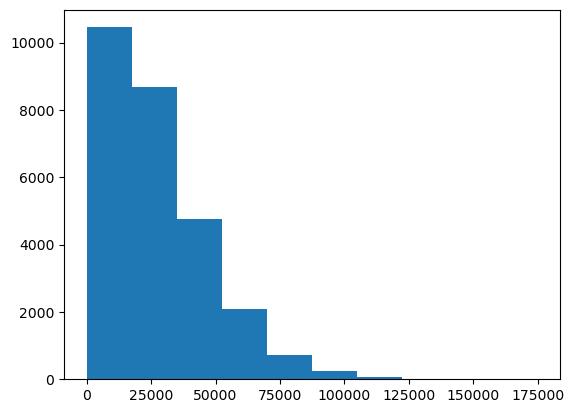

In [78]:
plt.hist(variances)
plt.show()

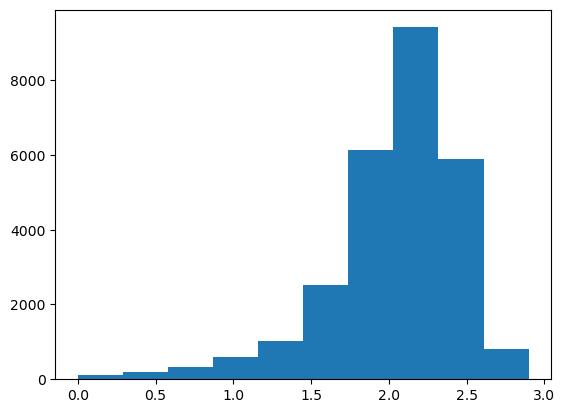

In [138]:
plt.hist(norm_shannon_entropies)
plt.show()

In [135]:
print([coords[i] for i in range(len(coords)) if norm_shannon_entropies[i] > 2.8])

[('chr11', 62664914, 62667028), ('chr6', 44252895, 44255009), ('chr1', 145992576, 145994690), ('chr6', 67886086, 67888200), ('chr11', 65426892, 65429006), ('chr3', 4985118, 4987232), ('chr12', 57515675, 57517789), ('chr11', 65500414, 65502528), ('chr17', 16442524, 16444638), ('chr12', 54285824, 54287938), ('chr6', 26054316, 26056430), ('chr9', 136672933, 136675047), ('chr6', 27139064, 27141178), ('chr2', 101006824, 101008938), ('chr5', 179611904, 179614018), ('chr6', 26156315, 26158429), ('chr22', 21623277, 21625391), ('chr6', 67880741, 67882855), ('chr22', 21622343, 21624457), ('chr3', 4984736, 4986850), ('chr6', 146892962, 146895076), ('chr12', 54285169, 54287283), ('chr18', 3652674, 3654788), ('chr11', 119093058, 119095172), ('chr19', 48966899, 48969013), ('chr6', 16265843, 16267957)]


In [137]:
print([coords[i] for i in range(len(coords)) if shannon_entropies[i] < 0.05])

[('chr9', 121546064, 121548178), ('chr8', 134969777, 134971891), ('chr22', 38935358, 38937472), ('chr2', 191322294, 191324408), ('chr3', 66468510, 66470624), ('chr3', 103081394, 103083508), ('chr6', 64558459, 64560573), ('chr8', 35175963, 35178077), ('chr5', 145753739, 145755853), ('chr3', 7023093, 7025207), ('chr5', 32220839, 32222953), ('chr4', 176734383, 176736497), ('chr8', 31585186, 31587300), ('chr3', 117426638, 117428752), ('chr18', 34268821, 34270935), ('chr7', 99250121, 99252235), ('chr2', 453076, 455190), ('chr10', 117546496, 117548610), ('chrX', 26358808, 26360922), ('chr3', 115167793, 115169907), ('chr7', 39860531, 39862645), ('chr7', 95581342, 95583456), ('chr3', 186843391, 186845505), ('chr3', 127676221, 127678335), ('chr10', 72046013, 72048127), ('chrX', 29425322, 29427436), ('chr3', 153274064, 153276178), ('chr6', 8164133, 8166247), ('chr3', 55358005, 55360119), ('chr7', 117381047, 117383161), ('chr12', 55873620, 55875734), ('chr4', 140849178, 140851292), ('chr6', 66328

In [6]:
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed

ccre_annots = find_peak_overlap_labels(coords, get_ccre_bed(cell_type), in_window, out_window)
val_ccre_annots = find_peak_overlap_labels(val_coords, get_ccre_bed(cell_type), in_window, out_window)

In [144]:
from load_annotations_utils import find_peak_overlap

housekeeping_genes_bed = proj_dir + "/annotations/hk_promoters.bed"

hk_annots = find_peak_overlap(coords, housekeeping_genes_bed)

tct_promoters_bed = proj_dir + "/annotations/tct_promoters.bed"

tct_annots = find_peak_overlap(coords, tct_promoters_bed)

In [8]:
onehot_seqs, true_profs = extract_peaks(genome_path,
                                        chrom_sizes,
                                        train_config.plus_bw_path,
                                        train_config.minus_bw_path,
                                        peak_path,
                                        in_window=in_window,
                                        out_window=out_window,
                                        max_jitter=0,
                                        verbose=True)

scores = load_scores(scores_path,
                     slice_len=slice_len,
                     in_window=in_window)

true_counts = true_profs.sum(axis=(1,2))  # strand-merged

pred_profs = np.exp(np.load(val_config.pred_profiles_train_val_path))
pred_counts = np.exp(np.load(val_config.pred_logcounts_train_val_path))

Loading genome sequence from /mnt/lab_data2/kcochran/new_procap_models/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.41it/s]
Loading Peaks: 27000it [00:48, 559.43it/s]


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/deepshap_out/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_train_and_val.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 27000
Mask loaded? False


In [9]:
val_profs = load_observed_profiles(val_config.plus_bw_path,
                                   val_config.minus_bw_path,
                                   val_config.val_peak_path,
                                   slice_len=slice_len,
                                   out_window=out_window)

val_counts = val_profs.sum(axis=(1,2))  # strand-merged

val_pred_counts = np.exp(np.load(val_config.pred_logcounts_val_path))

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/models/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_val.bed.gz
Profile length: 1000
Num. Examples: 3834


In [10]:
### Load Motifs

from motif_hits_utils import import_motif_hits, filter_peak_hits_by_fdr, make_peak_table, get_peak_hits_with_fix, get_peak_motif_counts

# this function differs slightly from Fig1.ipynb; to-do: standardize input for this

def load_motif_hits(modisco_results_path, train_val_peak_path, in_window, fdr_cutoff=0.05):
    modisco_hits_path = os.path.join(os.path.dirname(modisco_results_path), "motif_hits.bed")
    
    hits = import_motif_hits(modisco_hits_path)
    motif_keys = list(set(hits["key"]))

    # Filter motif hit table by p-value using FDR estimation
    filtered_hits = filter_peak_hits_by_fdr(hits, fdr_cutoff=fdr_cutoff)

    train_val_peak_table = make_peak_table(train_val_peak_path, in_window)

    # Match peaks to motif hits
    peak_hits = get_peak_hits_with_fix(train_val_peak_table, filtered_hits)

    # Count hits of each motif in each peak
    peak_hit_counts = get_peak_motif_counts(peak_hits, motif_keys)
    
    return filtered_hits, peak_hits, peak_hit_counts


motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(modisco_results_path, peak_path, in_window)

In [11]:
def make_motif_and_promoter_bools(motif_hit_counts, ccre_annots, motif_keys_to_labels,
                                  motifs_to_keep = ["TATA", "NotTATA", "CA-Inr", "TA-Inr"]):
    
    # true if motif j in peak i and peak i is promoter
    bools = (motif_hit_counts * ccre_annots["PLS"][..., None]) > 0
    # true if motif j NOT in peak i and peak i is promoter
    rev_bools = ((~ (motif_hit_counts > 0)) * ccre_annots["PLS"][..., None]) > 0
    
    motif_promoter_bools = dict()
    for motif_key, motif_label in enumerate(motif_keys_to_labels):
        if motif_label in motifs_to_keep:
            motif_promoter_bools[motif_label] = bools[:, motif_key]
        if "Not" + motif_label in motifs_to_keep:
            motif_promoter_bools["Not" + motif_label] = rev_bools[:, motif_key]
            
    return motif_promoter_bools
    
    
motif_and_promoter_bools = make_motif_and_promoter_bools(motif_hit_counts, ccre_annots, motif_keys_to_labels)

In [12]:
motif_and_promoter_bools

{'CA-Inr': array([ True, False, False, ..., False, False, False]),
 'TA-Inr': array([False, False, False, ..., False, False, False]),
 'TATA': array([False, False, False, ..., False, False, False]),
 'NotTATA': array([ True, False, False, ..., False, False, False])}

In [13]:
[np.sum(motif_and_promoter_bools[key]) for key in motif_and_promoter_bools.keys()]

[4742, 435, 1111, 13718]

In [14]:
motifs_to_colors = {"TATA" : "tab:blue",
                    "NotTATA" : "tab:orange",
                    "CA-Inr" : "tab:green",
                    "TA-Inr" : "tab:red"}

annots_to_colors = {"HK" : "tab:purple",
                    "TCT" : "tab:brown"}

class_to_colors = dict(motifs_to_colors, **annots_to_colors)  # merges the two

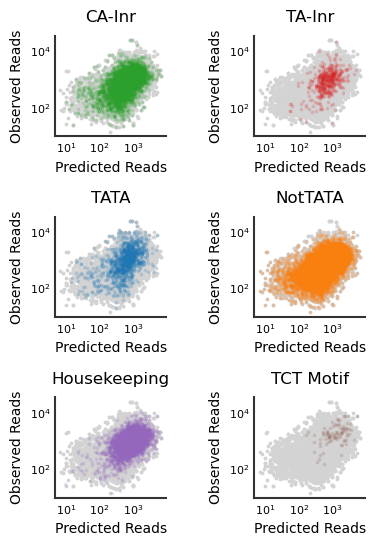

In [145]:
def plot_true_pred_counts_by_annot(true_counts, pred_counts, motif_and_promoter_bools, hk_annots, tct_annots):

    motifs_to_plot = motif_and_promoter_bools.keys()
    fig, axes = plt.subplots(3,2,figsize=(4,6))
    axes = axes.flatten()
    
    ax_index = 0
    for motif_name in motifs_to_plot:
        other_x = []
        other_y = []
        for other_motif_name in motifs_to_plot:
            other_x.extend(pred_counts[motif_and_promoter_bools[other_motif_name]])
            other_y.extend(true_counts[motif_and_promoter_bools[other_motif_name]])

        axes[ax_index].scatter(other_x, other_y, alpha = 1, s = 3,
                                label = "Other", color = "lightgray")
        
        # have to plot last
        true_counts_subset = true_counts[motif_and_promoter_bools[motif_name]].squeeze()
        pred_counts_subset = pred_counts[motif_and_promoter_bools[motif_name]].squeeze()
        
        axes[ax_index].scatter(pred_counts_subset, true_counts_subset, alpha = 0.15, s = 3,
                                label = motif_name,
                                color = motifs_to_colors[motif_name])

        axes[ax_index].semilogy()
        axes[ax_index].semilogx()

        axes[ax_index].set_xlabel("Predicted Reads", fontsize = 10)
        axes[ax_index].set_ylabel("Observed Reads", fontsize = 10)

        
        for side in ["left", "bottom"]:
            axes[ax_index].spines[side].set_linewidth(1.5)
            axes[ax_index].spines[side].set_color("#333333")
        for side in ["top", "right"]:
            axes[ax_index].spines[side].set_visible(False)
        
        axes[ax_index].xaxis.set_ticks_position('none') 
        axes[ax_index].yaxis.set_ticks_position('none')
        axes[ax_index].tick_params(axis='both', labelsize=8, length=0)
        
        axes[ax_index].set_title(motif_name, fontsize=12, pad=10)
        
        ax_index += 1
        
        
    # hk promoters
        
    axes[ax_index].scatter(other_x, other_y, alpha = 1, s = 3,
                                label = "Other", color = "lightgray")
        
    true_counts_subset = true_counts[hk_annots].squeeze()
    pred_counts_subset = pred_counts[hk_annots].squeeze()

    axes[ax_index].scatter(pred_counts_subset, true_counts_subset, alpha = 0.15, s = 3,
                            label = motif_name,
                            color = annots_to_colors["HK"])

    axes[ax_index].semilogy()
    axes[ax_index].semilogx()

    axes[ax_index].set_xlabel("Predicted Reads", fontsize = 10)
    axes[ax_index].set_ylabel("Observed Reads", fontsize = 10)


    for side in ["left", "bottom"]:
        axes[ax_index].spines[side].set_linewidth(1.5)
        axes[ax_index].spines[side].set_color("#333333")
    for side in ["top", "right"]:
        axes[ax_index].spines[side].set_visible(False)

    axes[ax_index].xaxis.set_ticks_position('none') 
    axes[ax_index].yaxis.set_ticks_position('none')
    axes[ax_index].tick_params(axis='both', labelsize=8, length=0)

    axes[ax_index].set_title("Housekeeping", fontsize=12, pad=10)

    ax_index += 1
    
    
    # TCT promoters
        
    axes[ax_index].scatter(other_x, other_y, alpha = 1, s = 3,
                                label = "Other", color = "lightgray")
        
    true_counts_subset = true_counts[tct_annots].squeeze()
    pred_counts_subset = pred_counts[tct_annots].squeeze()

    axes[ax_index].scatter(pred_counts_subset, true_counts_subset, alpha = 0.15, s = 3,
                            label = motif_name,
                            color = annots_to_colors["TCT"])

    axes[ax_index].semilogy()
    axes[ax_index].semilogx()

    axes[ax_index].set_xlabel("Predicted Reads", fontsize = 10)
    axes[ax_index].set_ylabel("Observed Reads", fontsize = 10)


    for side in ["left", "bottom"]:
        axes[ax_index].spines[side].set_linewidth(1.5)
        axes[ax_index].spines[side].set_color("#333333")
    for side in ["top", "right"]:
        axes[ax_index].spines[side].set_visible(False)

    axes[ax_index].xaxis.set_ticks_position('none') 
    axes[ax_index].yaxis.set_ticks_position('none')
    axes[ax_index].tick_params(axis='both', labelsize=8, length=0)

    axes[ax_index].set_title("TCT Motif", fontsize=12, pad=10)

    ax_index += 1

    plt.subplots_adjust(wspace=0.8, hspace=0.8)
    plt.show()

    
plot_true_pred_counts_by_annot(true_counts, pred_counts, motif_and_promoter_bools, hk_annots, tct_annots)

In [16]:
from BPNet_strand_merged_umap import Model
import torch

# re-define the model's forward func so that it returns output of intermediate layer

class BPNet_Embeddings_Loader(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming

        X = self.relus[0](self.iconv(X))

        for i in range(self.n_layers):
            X_conv = self.relus[i+1](self.rconvs[i](X))
            X = torch.add(X, X_conv)
            
        X = X[:, :, start - self.deconv_kernel_size//2 : end + self.deconv_kernel_size//2]

        # return result of global avg pooling
        # (beginning of counts head, before linear layer)
        X = torch.mean(X, axis=2)
        return X

    
# the arch-related args here have to match what was input when the model was trained
params = load_json(train_config.params_path)

embedder = BPNet_Embeddings_Loader("_",
                                   n_filters=params["n_filters"],
                                   n_layers=params["n_layers"],
                                   trimming=params["trimming"],
                                   alpha=params["counts_weight"])

loaded_model_state = torch.load(train_config.model_save_path).state_dict()
embedder.load_state_dict(loaded_model_state)

<All keys matched successfully>

In [17]:
embedder

BPNet_Embeddings_Loader(
  (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
  (rconvs): ModuleList(
    (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (fconv): Conv1d(512, 2, kernel_size=(75,), stride=(1,))
  (relus): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): ReLU()
    (5): Re

In [18]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-40f43250-998e-586a-ac37-d6520e92590f"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

embedder.eval()
embedder = embedder.cuda()

In [19]:
def get_embeddings(embedder, seqs, batch_size=128):
    if not seqs.shape[-2] == 4:
        seqs = np.swapaxes(seqs, -2, -1)
    seqs = torch.tensor(seqs, dtype=torch.float)
    embedder = embedder.cuda()
    with torch.no_grad():
        starts = np.arange(0, seqs.shape[0], batch_size)
        ends = starts + batch_size

        embeds = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if i % 10 == 0:
                print("Batch " + str(i) + " of " + str(len(starts)))
            
            seqs_batch = seqs[start:end]
            embeds_batch = embedder(seqs_batch.cuda()).cpu().detach().numpy()
            embeds.append(embeds_batch)

    embedder = embedder.cpu()
    return np.concatenate(embeds)

peak_embeds = get_embeddings(embedder, onehot_seqs)

Batch 0 of 211
Batch 10 of 211
Batch 20 of 211
Batch 30 of 211
Batch 40 of 211
Batch 50 of 211
Batch 60 of 211
Batch 70 of 211
Batch 80 of 211
Batch 90 of 211
Batch 100 of 211
Batch 110 of 211
Batch 120 of 211
Batch 130 of 211
Batch 140 of 211
Batch 150 of 211
Batch 160 of 211
Batch 170 of 211
Batch 180 of 211
Batch 190 of 211
Batch 200 of 211
Batch 210 of 211


In [20]:
embeds_by_class = dict()
for motif_name in motif_and_promoter_bools.keys():
    embeds_by_class[motif_name] = peak_embeds[motif_and_promoter_bools[motif_name]]
    
embeds_by_class["HK"] = peak_embeds[hk_annots]
embeds_by_class["TCT"] = peak_embeds[tct_annots]

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pcs = pca.fit(peak_embeds)

pcs_by_class = dict()
for key in embeds_by_class.keys():
    pcs_by_class[key] = pca.transform(embeds_by_class[key])

In [22]:
peak_pcs = pca.transform(peak_embeds)

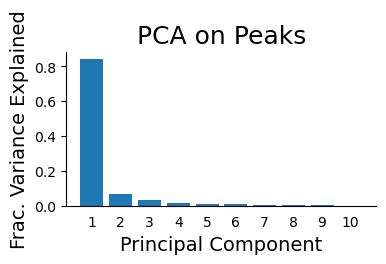

In [23]:
plt.figure(figsize=(4,2))
plt.bar(range(1, 10+1), pca.explained_variance_ratio_)
plt.xlabel("Principal Component", fontsize = 14)
plt.ylabel("Frac. Variance Explained", fontsize = 14)
plt.title("PCA on Peaks", fontsize = 18)

plt.xticks(range(1, 10+1))
for side in ["right", "top"]:
    plt.gca().spines[side].set_visible(False)
plt.gca().xaxis.set_ticks_position('none') 

plt.show()

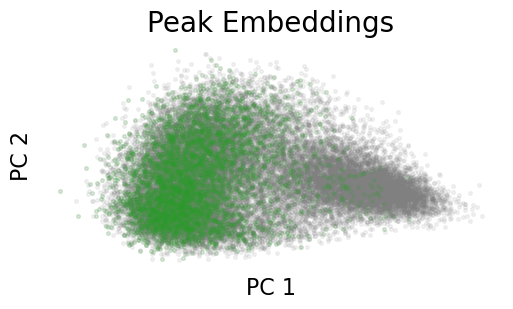

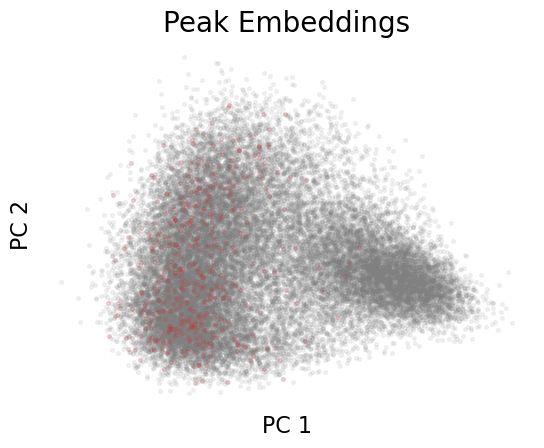

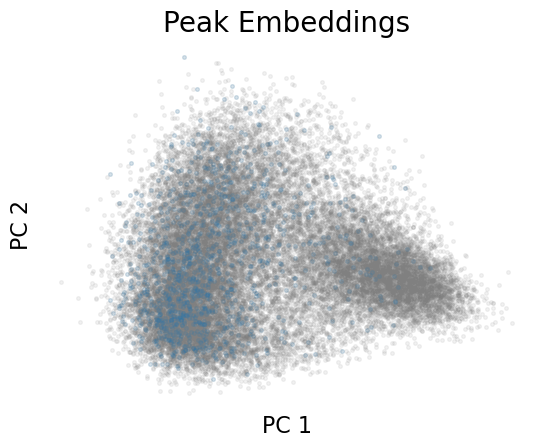

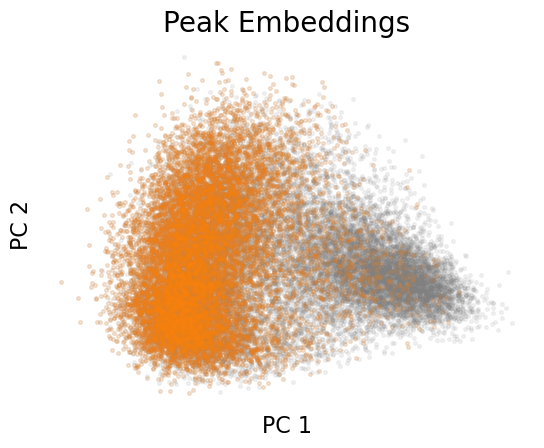

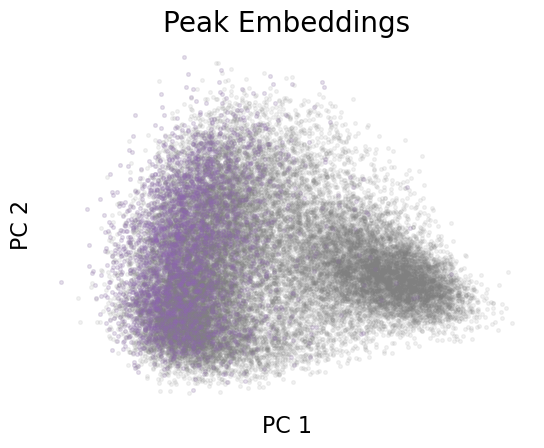

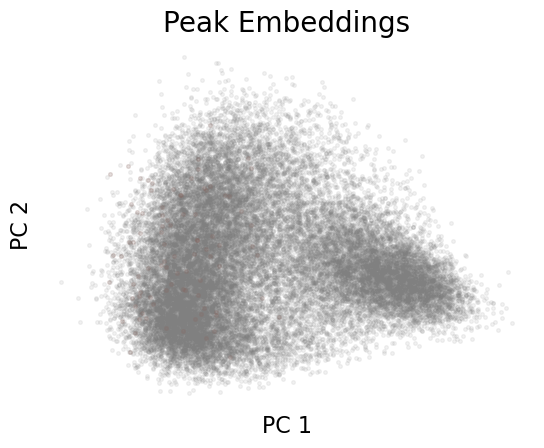

In [24]:
from matplotlib.lines import Line2D

def plot_embeds_pca(peak_pcs, pcs_by_class):
    plt.figure(figsize=(6,3))

    for key in pcs_by_class.keys():
        plt.scatter(peak_pcs[..., 0], peak_pcs[..., 1],
                alpha = 0.1, s = 7, c="gray")
        
        plt.scatter(pcs_by_class[key][..., 0], pcs_by_class[key][..., 1],
                alpha = 0.12, s = 7, c=class_to_colors[key])

        plt.xlabel("PC 1", fontsize = 16)
        plt.ylabel("PC 2", fontsize = 16)
        plt.title("Peak Embeddings", fontsize = 20)

        for side in ["right", "top", "bottom", "left"]:
            plt.gca().spines[side].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.tick_params("both", length=0)

        plt.show()

    
plot_embeds_pca(peak_pcs, pcs_by_class)

In [25]:
def get_orientation_indexes(profiles):
    return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))

ois = get_orientation_indexes(true_profs)

In [26]:
def inverse_hist(profile):
    assert len(profile.shape) == 1 or (len(profile.shape) == 2 and profile.shape[0] == 2), profile.shape

    profile = profile.sum(axis=0).astype(int)
    return np.repeat(range(len(profile)), profile)

def get_variances(profiles):
    return np.array([np.var(inverse_hist(profile)) for profile in profiles])

variances = get_variances(true_profs)

In [146]:
def get_shannon_entropies(profiles):
    assert len(profiles.shape) >= 2, profiles.shape
    profiles_strand_sum = profiles.sum(axis=-2)
    
    profiles_norm = profiles_strand_sum / profiles_strand_sum.sum(axis=-1, keepdims=True)
    profiles_norm_log = np.log(profiles_norm + 1e-20)
    
    entropies = - (profiles_norm * profiles_norm_log).sum(axis=-1)
    return entropies

shannon_entropies = get_shannon_entropies(true_profs)
norm_shannon_entropies = shannon_entropies / np.log(np.log(true_counts))

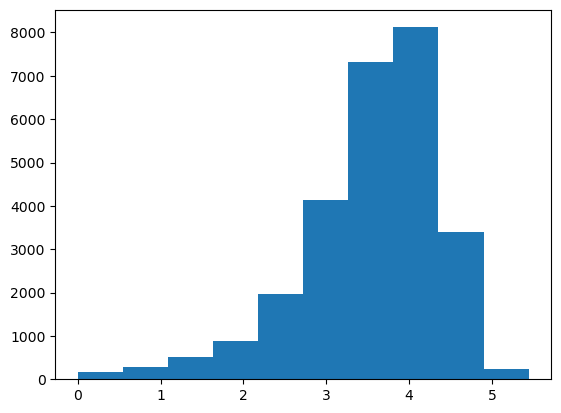

In [128]:
plt.hist(shannon_entropies)
plt.show()

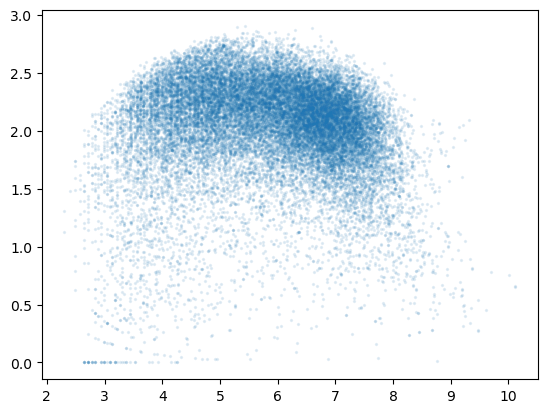

In [126]:
plt.scatter(np.log(true_counts), shannon_entropies / np.log(np.log(true_counts)), s=2, alpha=0.1)
#plt.semilogx()
#plt.semilogy()
plt.show()

In [147]:
ois_by_class = dict()
for key in motif_and_promoter_bools.keys():
    ois_by_class[key] = ois[motif_and_promoter_bools[key]]
    
ois_by_class["HK"] = ois[hk_annots]
ois_by_class["TCT"] = ois[tct_annots]

In [148]:
vars_by_class = dict()
for motif_name in motif_and_promoter_bools.keys():
    vars_by_class[motif_name] = variances[motif_and_promoter_bools[motif_name]]
    
vars_by_class["HK"] = variances[hk_annots]
vars_by_class["TCT"] = variances[tct_annots]

In [149]:
entropies_by_class = dict()
for motif_name in motif_and_promoter_bools.keys():
    entropies_by_class[motif_name] = norm_shannon_entropies[motif_and_promoter_bools[motif_name]]
    
entropies_by_class["HK"] = norm_shannon_entropies[hk_annots]
entropies_by_class["TCT"] = norm_shannon_entropies[tct_annots]

In [150]:
counts_by_class = dict()
for motif_name in motif_and_promoter_bools.keys():
    counts_by_class[motif_name] = true_counts[motif_and_promoter_bools[motif_name]]
    
counts_by_class["HK"] = true_counts[hk_annots]
counts_by_class["TCT"] = true_counts[tct_annots]

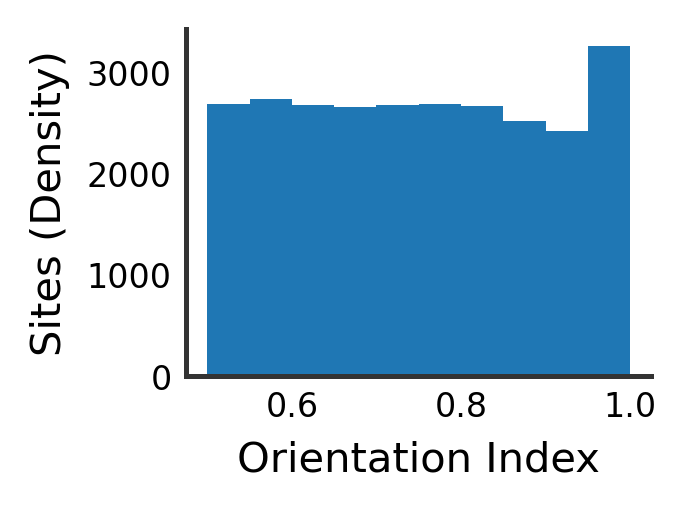

In [29]:
plt.figure(figsize=(2,1.5), dpi=300)

plt.hist(ois)

plt.xlabel("Orientation Index", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

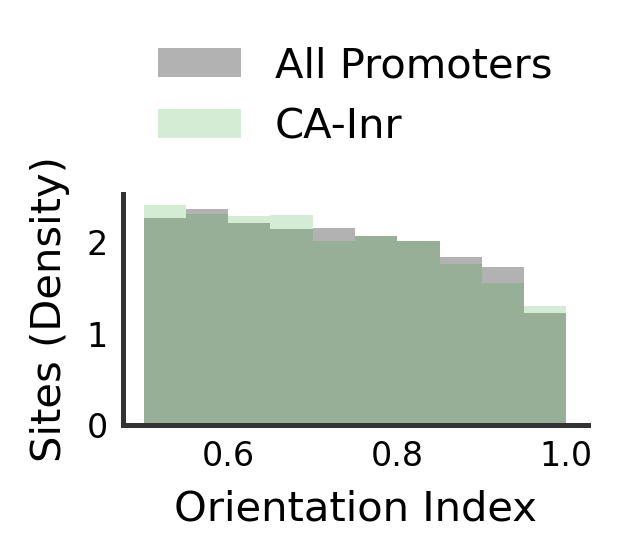

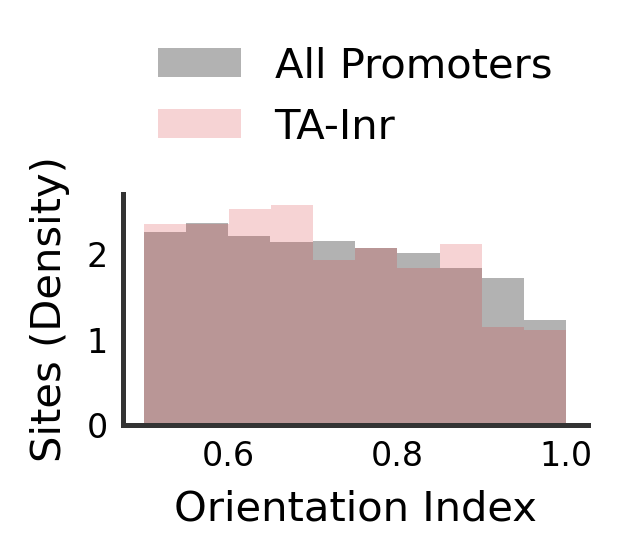

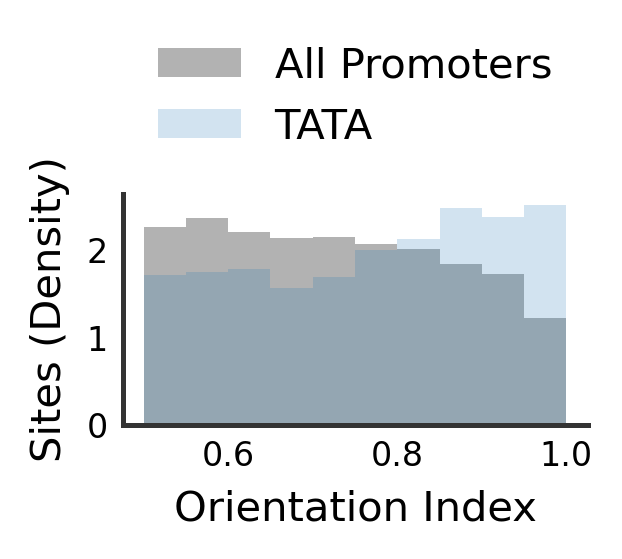

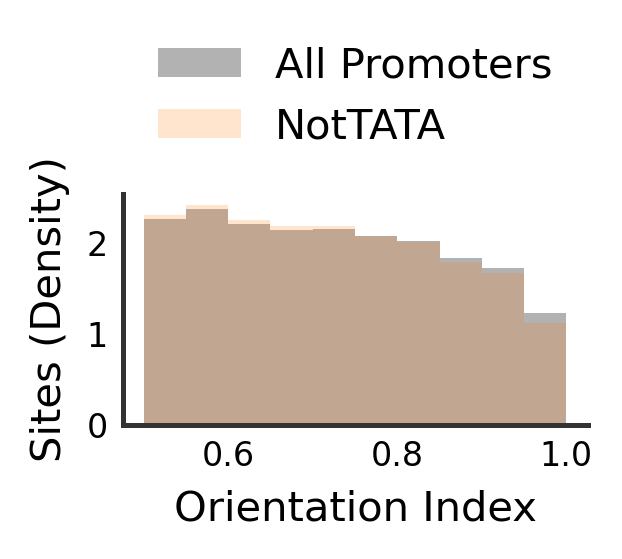

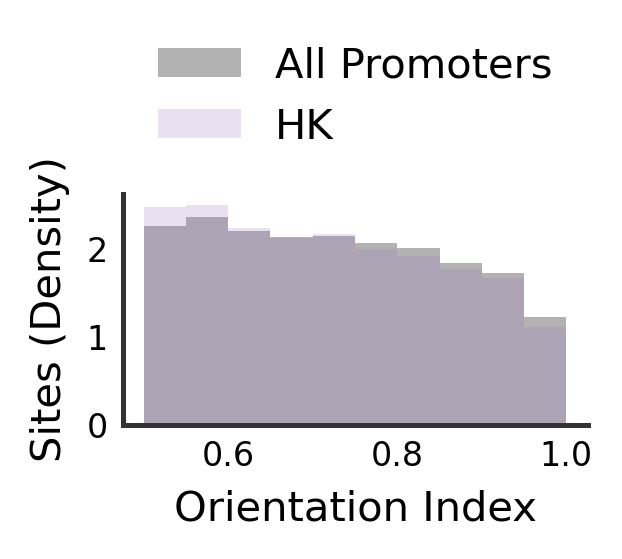

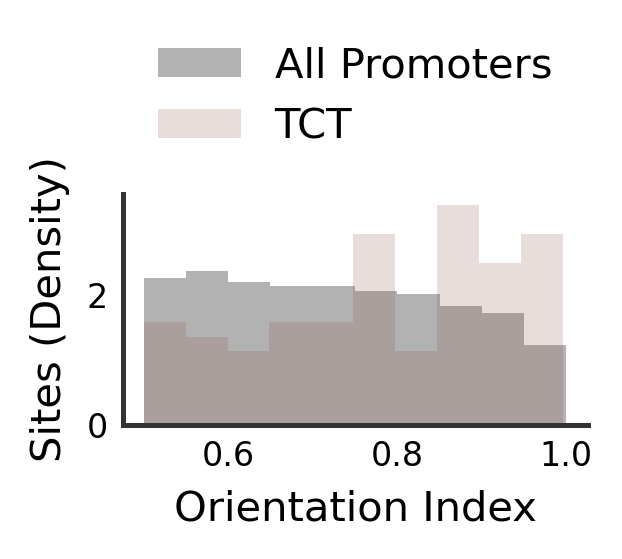

In [151]:
for motif_name, class_ois in ois_by_class.items():
    plt.figure(figsize=(2,1), dpi=300)
    
    plt.hist(ois[ccre_annots["PLS"]], density=True, alpha=0.6, label="All Promoters", color="gray")

    
    plt.hist(class_ois, density=True, alpha=0.2, label=motif_name, color=class_to_colors[motif_name])

    plt.xlabel("Orientation Index", fontsize=10)
    plt.ylabel("Sites (Density)", fontsize=10)
    plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(length=0, labelsize=8)

    plt.show()

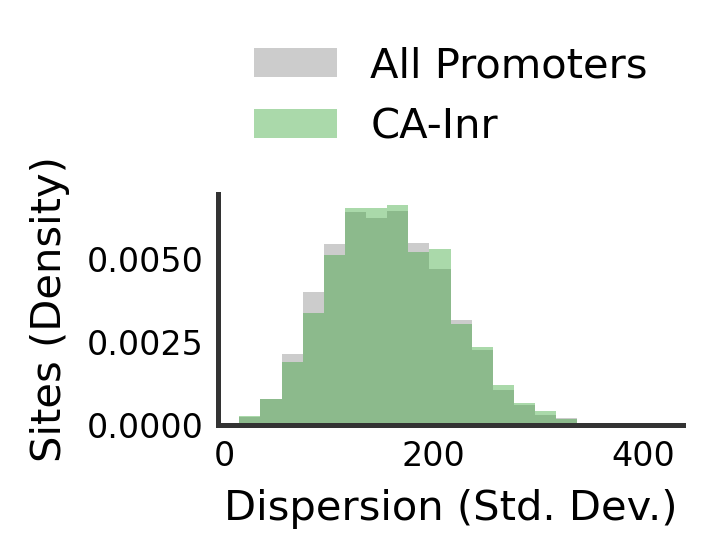

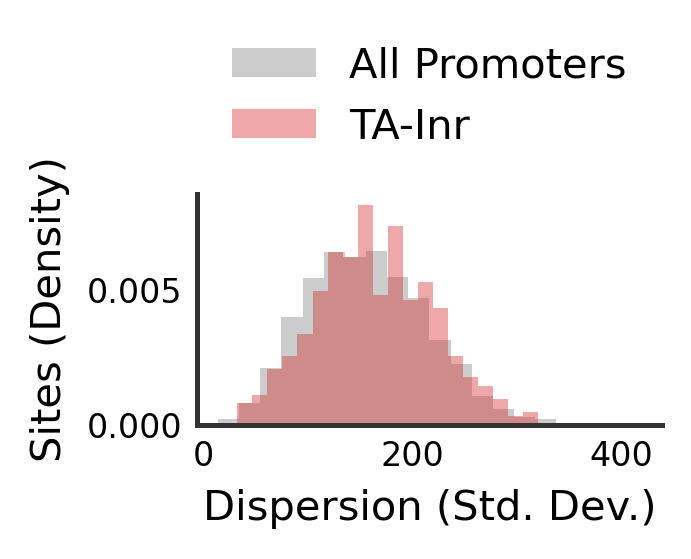

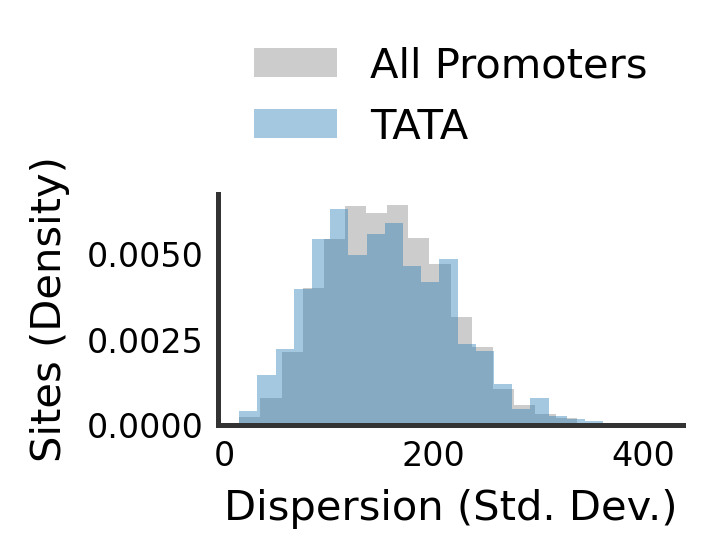

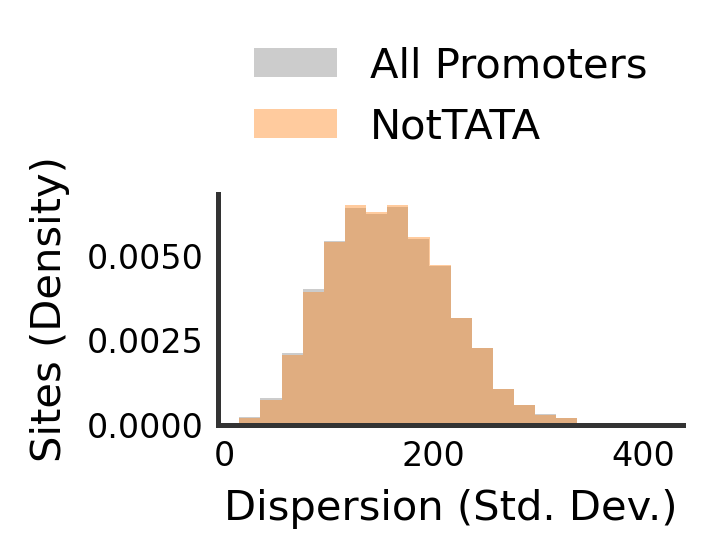

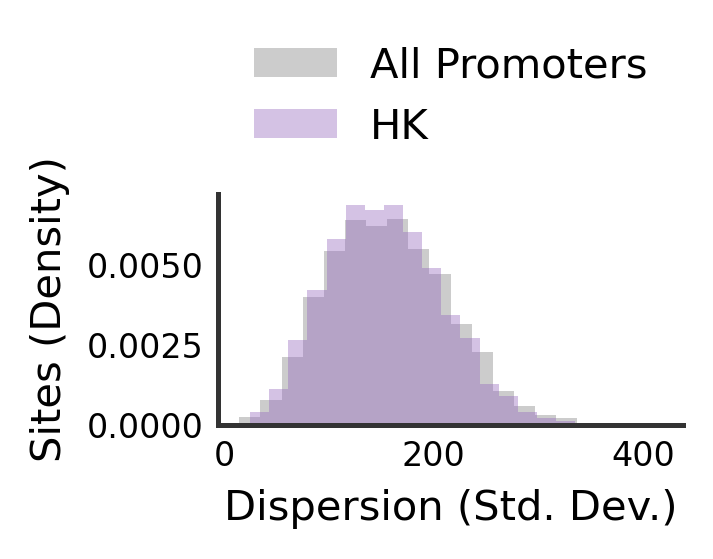

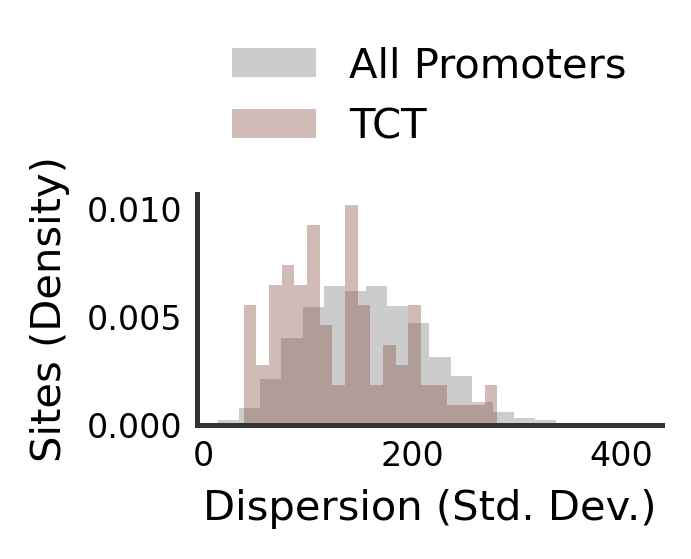

In [152]:
for motif_name, class_vars in vars_by_class.items():
    plt.figure(figsize=(2,1), dpi=300)

    plt.hist(np.sqrt(variances[ccre_annots["PLS"]]), density=True, alpha=0.4, label="All Promoters", color="gray", bins=20)

    
    plt.hist(np.sqrt(class_vars), density=True, alpha=0.4, label=motif_name, color=class_to_colors[motif_name], bins=20)
    
    plt.xlabel("Dispersion (Std. Dev.)", fontsize=10)
    plt.ylabel("Sites (Density)", fontsize=10)
    plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(length=0, labelsize=8)

    plt.show()

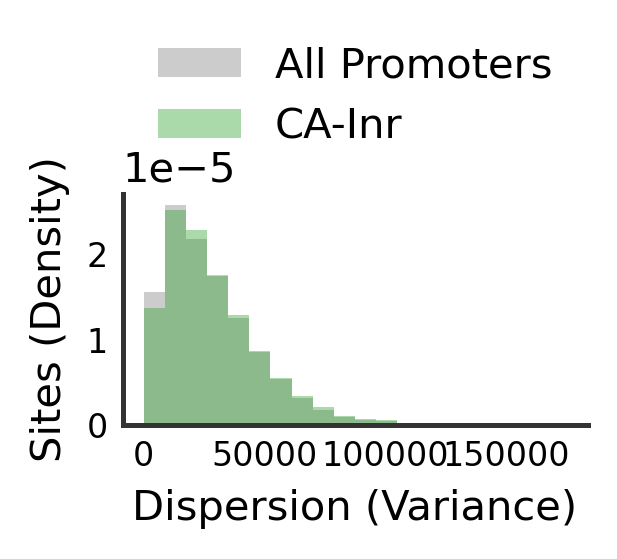

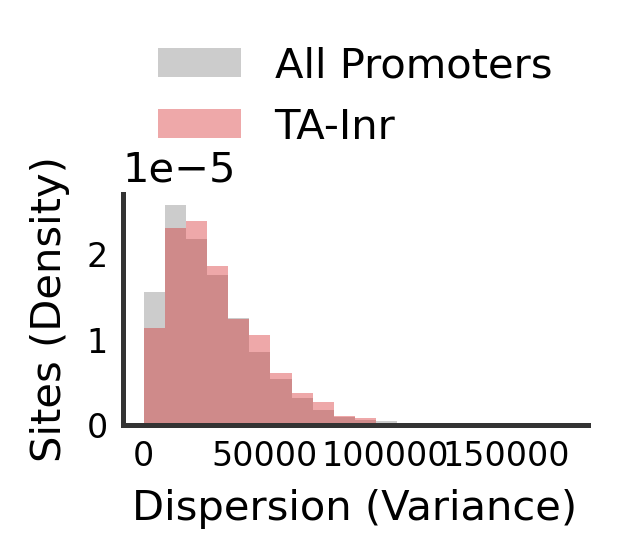

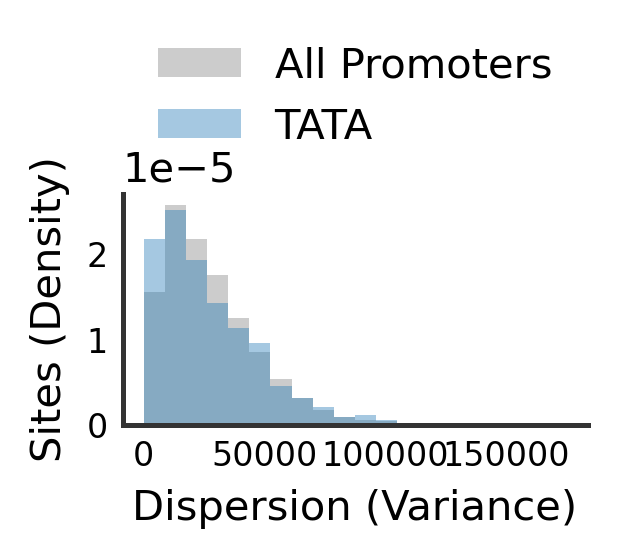

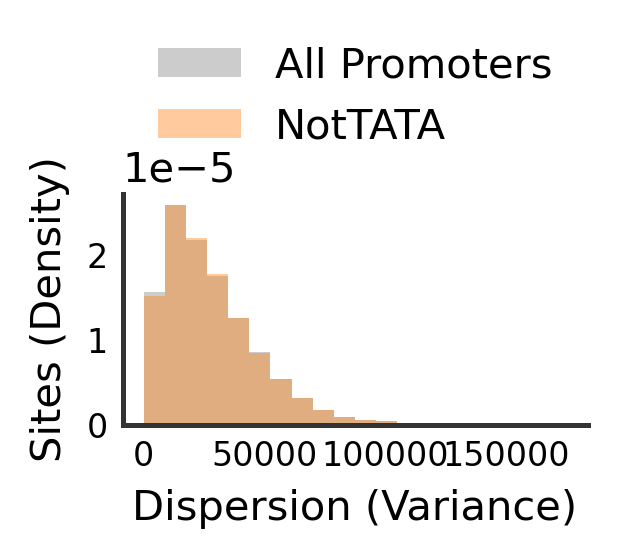

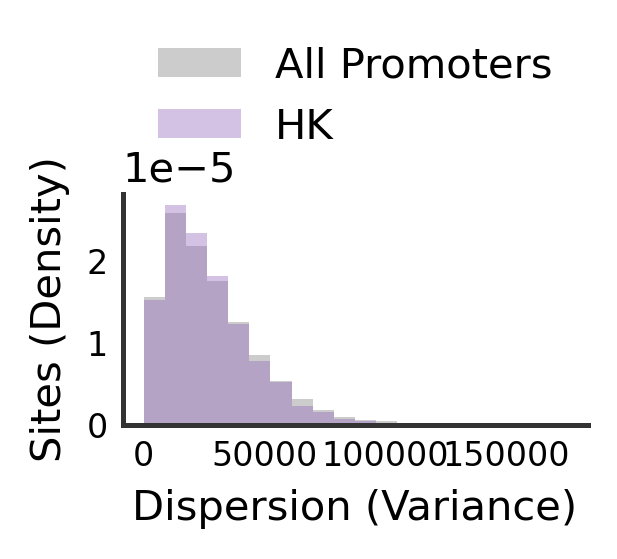

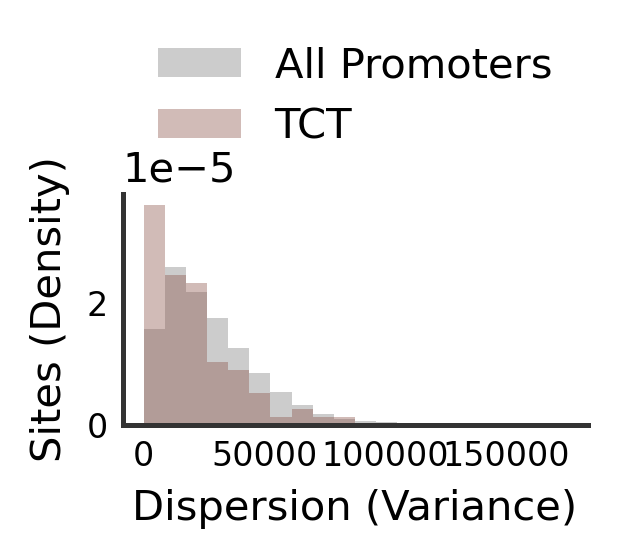

In [153]:
for motif_name, class_vars in vars_by_class.items():
    plt.figure(figsize=(2,1), dpi=300)

    bins = np.arange(0, np.max(variances[ccre_annots["PLS"]]), np.max(variances[ccre_annots["PLS"]]) // 20)
    plt.hist(variances[ccre_annots["PLS"]], density=True, alpha=0.4, label="All Promoters", color="gray", bins=bins)

    
    plt.hist(class_vars, density=True, alpha=0.4, label=motif_name, color=class_to_colors[motif_name], bins=bins)
    
    plt.xlabel("Dispersion (Variance)", fontsize=10)
    plt.ylabel("Sites (Density)", fontsize=10)
    plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(length=0, labelsize=8)

    plt.show()

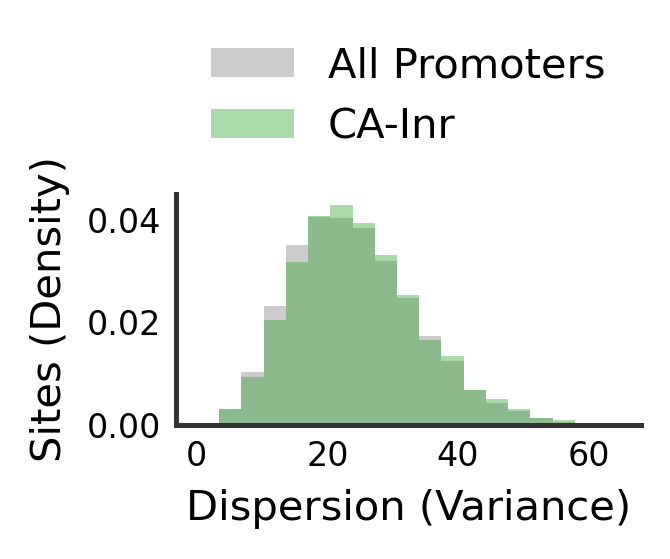

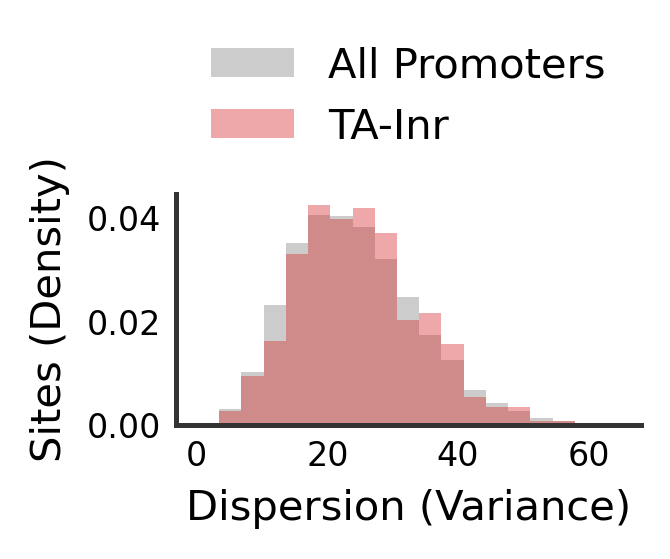

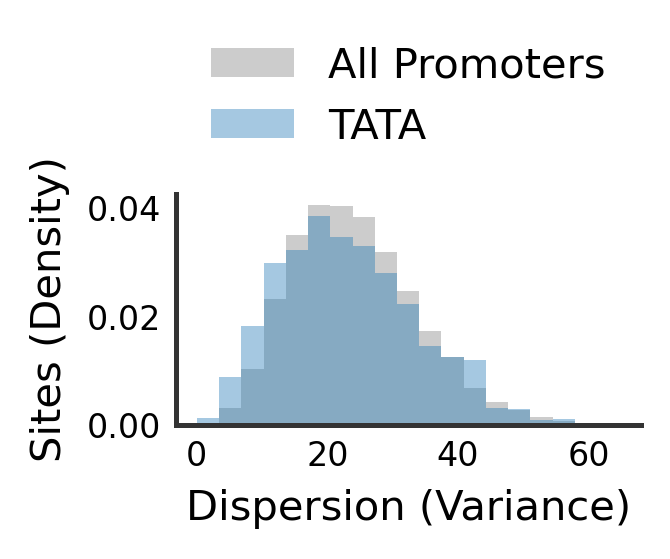

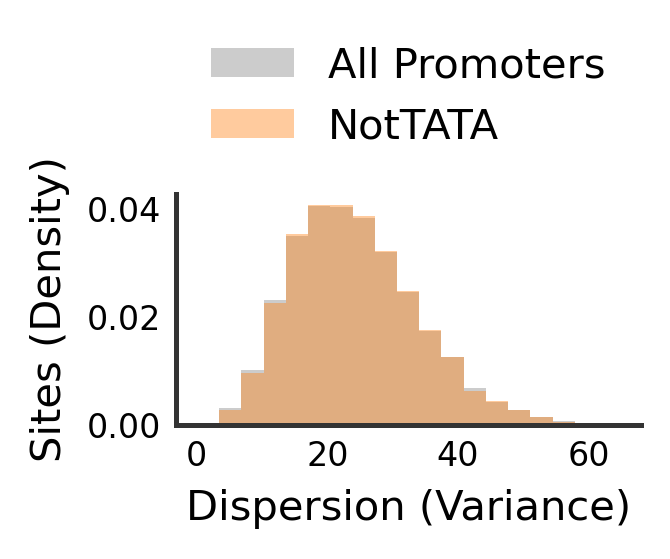

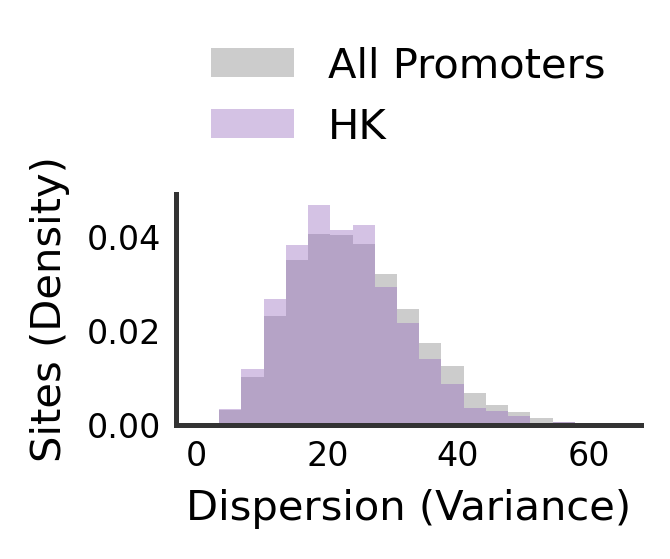

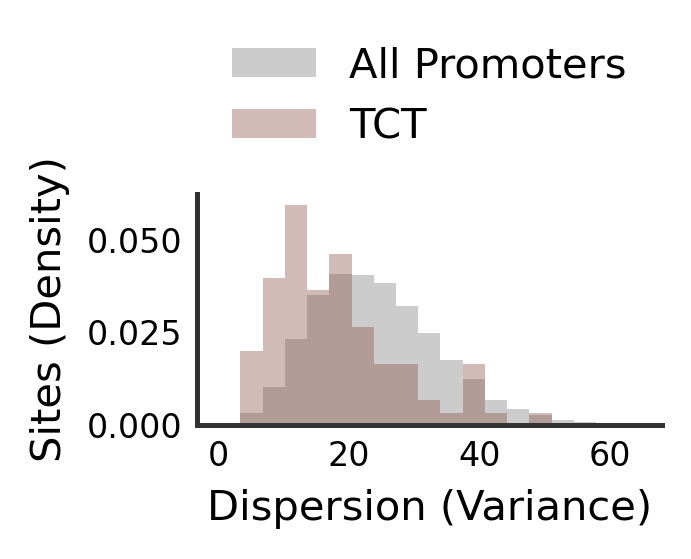

In [154]:
for motif_name, class_vars in vars_by_class.items():
    plt.figure(figsize=(2,1), dpi=300)

    all_promoters = (np.sqrt(variances) / np.log(true_counts + 1))[ccre_annots["PLS"]]
    bins = np.arange(0, np.max(all_promoters), np.max(all_promoters) / 20)
    plt.hist(all_promoters, density=True, alpha=0.4, label="All Promoters", color="gray", bins=bins)

    
    plt.hist(np.sqrt(class_vars) / np.log(counts_by_class[motif_name] + 1), density=True, alpha=0.4, label=motif_name, color=class_to_colors[motif_name], bins=bins)
    
    plt.xlabel("Dispersion (Variance)", fontsize=10)
    plt.ylabel("Sites (Density)", fontsize=10)
    plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(length=0, labelsize=8)

    plt.show()

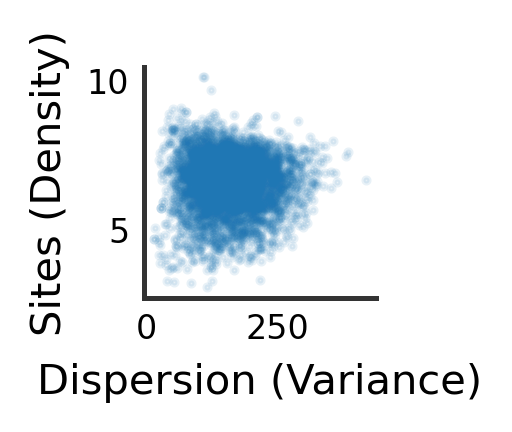

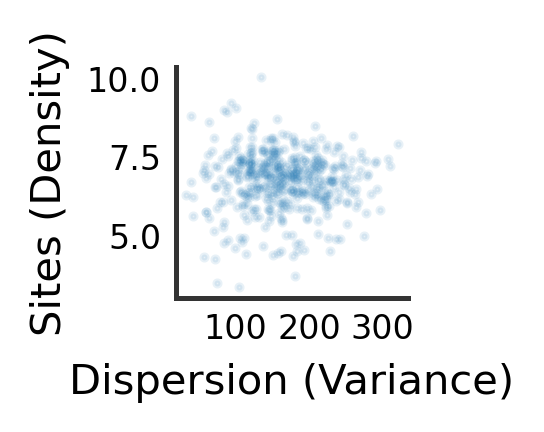

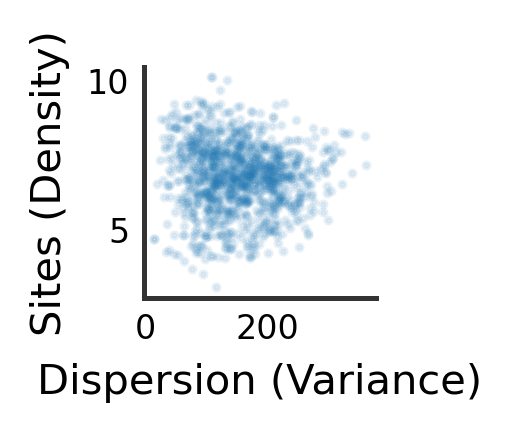

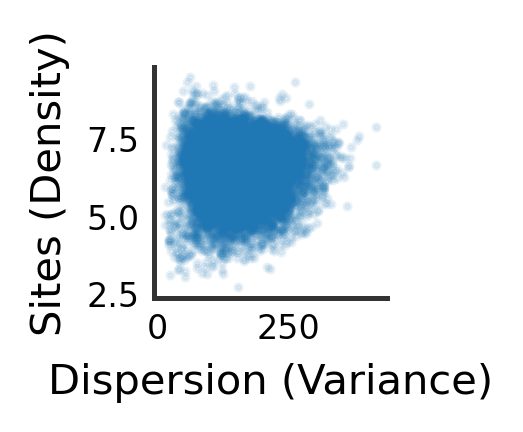

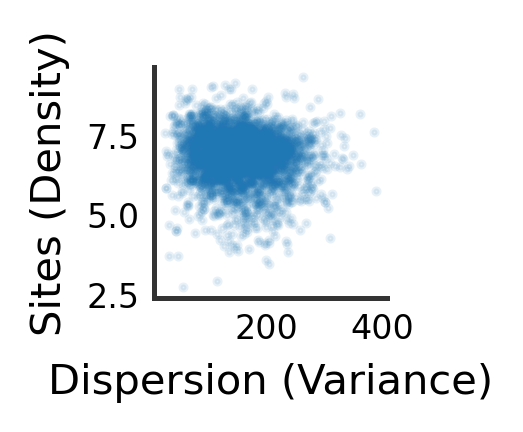

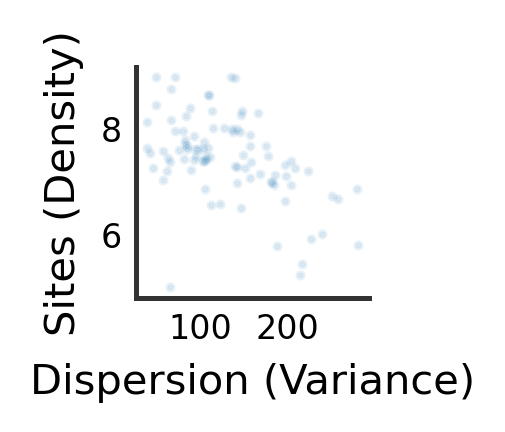

In [155]:
for motif_name, class_vars in vars_by_class.items():
    plt.figure(figsize=(1,1), dpi=300)
    
    plt.scatter(np.sqrt(class_vars), np.log(counts_by_class[motif_name] + 1), alpha=0.1, s=2)
    
    plt.xlabel("Dispersion (Variance)", fontsize=10)
    plt.ylabel("Sites (Density)", fontsize=10)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(length=0, labelsize=8)

    plt.show()

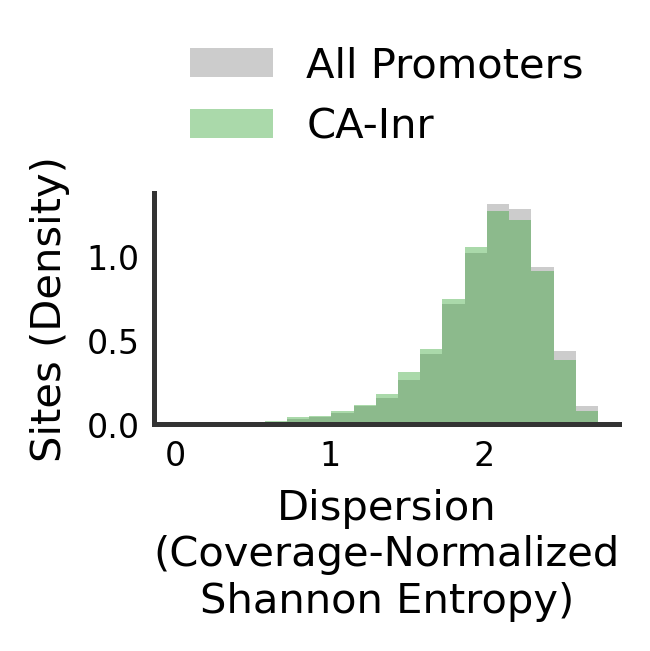

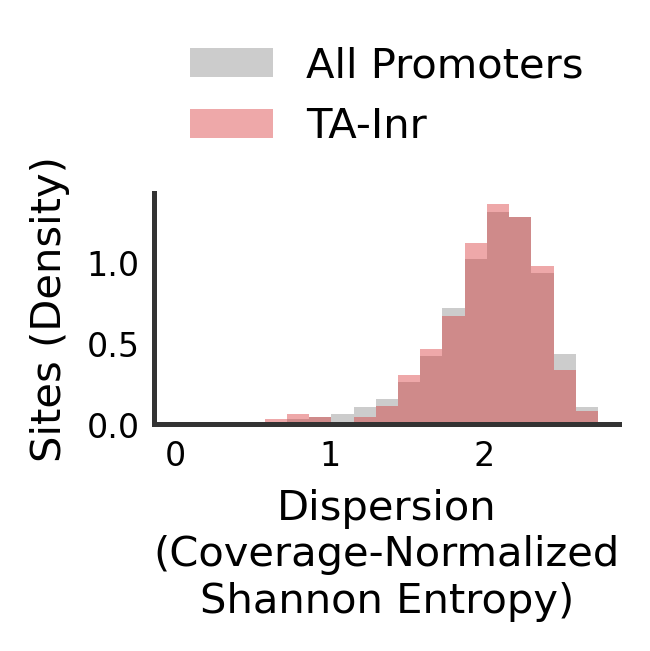

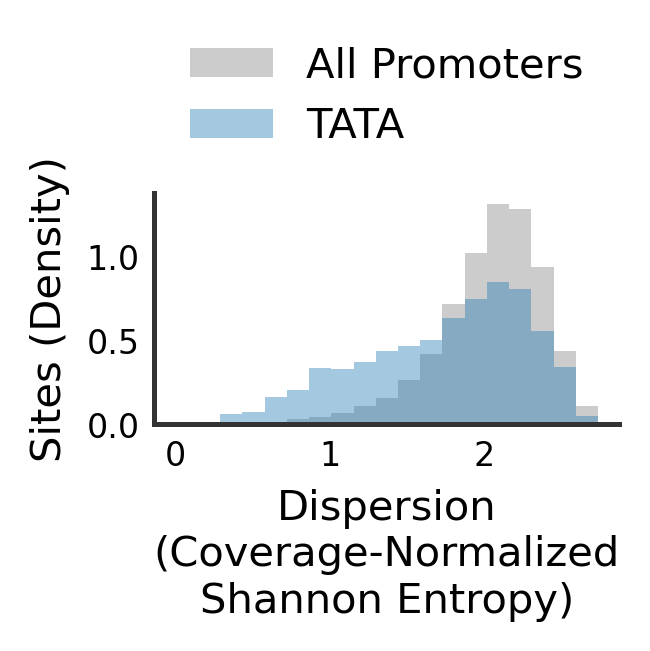

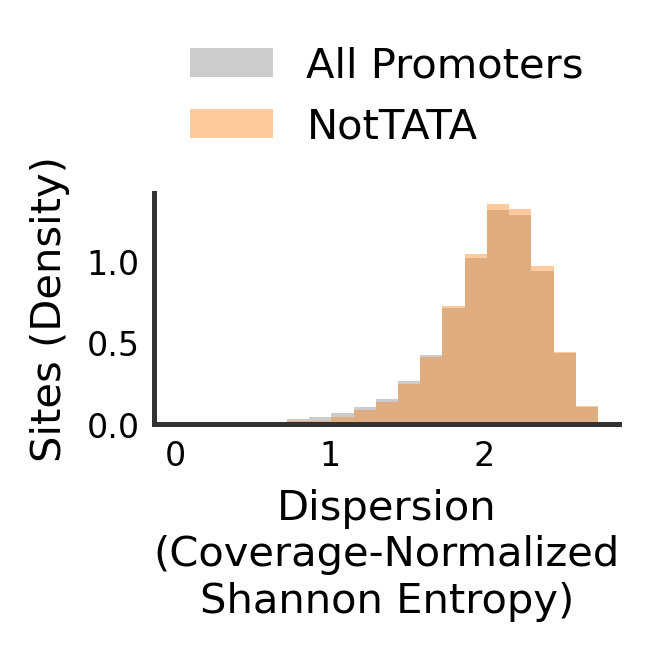

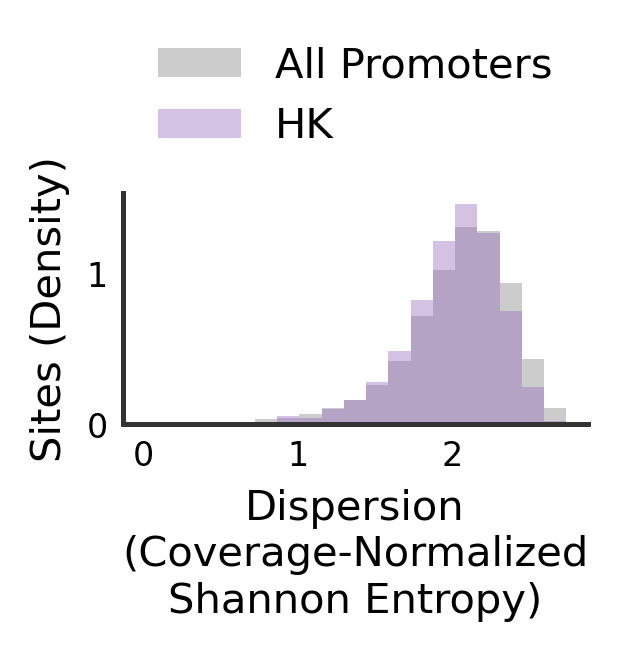

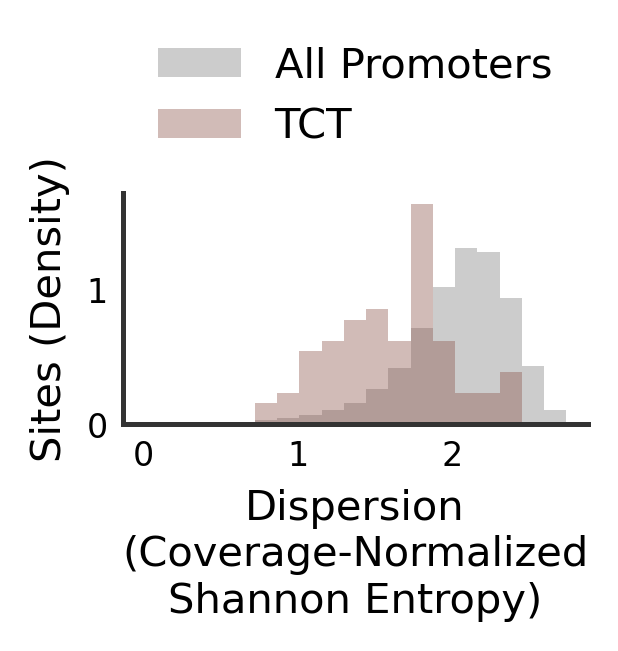

In [156]:
for motif_name, class_entropies in entropies_by_class.items():
    plt.figure(figsize=(2,1), dpi=300)

    all_promoters = norm_shannon_entropies[ccre_annots["PLS"]]
    bins = np.arange(0, np.max(all_promoters), np.max(all_promoters) / 20)
    plt.hist(all_promoters, density=True, alpha=0.4, label="All Promoters", color="gray", bins=bins)

    
    plt.hist(class_entropies, density=True, alpha=0.4, label=motif_name, color=class_to_colors[motif_name], bins=bins)
    
    plt.xlabel("Dispersion\n(Coverage-Normalized\nShannon Entropy)", fontsize=10)
    plt.ylabel("Sites (Density)", fontsize=10)
    plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(length=0, labelsize=8)

    plt.show()

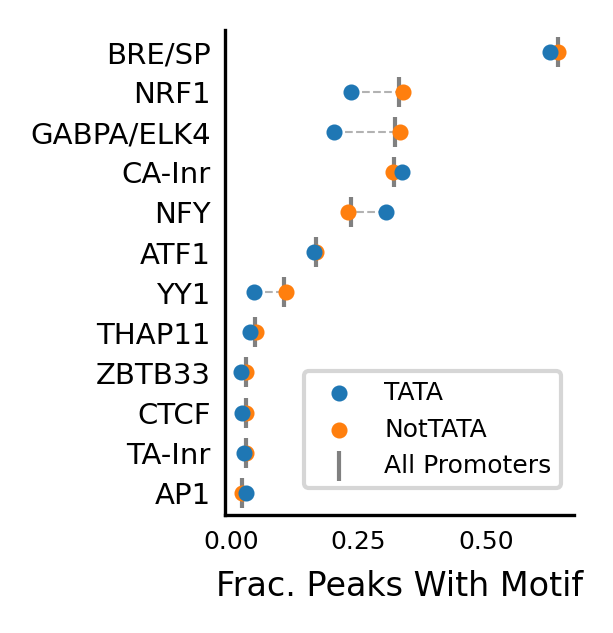

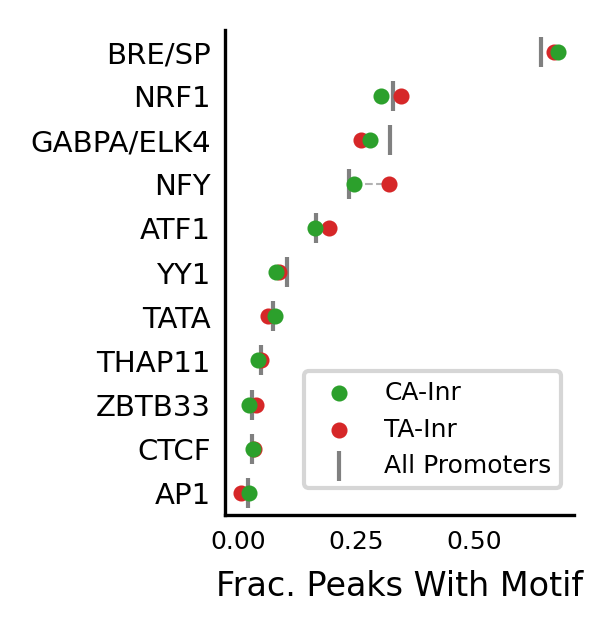

In [32]:
from collections import defaultdict

def plot_motif_enrichment_in_cCREs_condensed(peak_hit_counts, ccre_annots, motif_and_promoter_bools,
                                        annots_to_plot = ["TATA", "NotTATA"]):
    
    annots_to_sizes = {"All Promoters" : 50, "PLS" : 45, "dELS" : 45}
    
    annot_vals = defaultdict(lambda : [])
    
    num_peaks_in_promoters = np.sum(ccre_annots["PLS"])
    
    motif_names_to_plot = []
    motif_keys = range(peak_hit_counts.shape[1])
    for motif_index in motif_keys:
        if motif_keys_to_labels[motif_index] in annots_to_plot:
            continue
            
        motif_names_to_plot.append(motif_keys_to_labels[motif_index])
            
        total_peaks_with_motif = np.sum(peak_hit_counts[ccre_annots["PLS"], motif_index] > 0)

        for key in annots_to_plot:
            overlap_peaks = np.sum(motif_and_promoter_bools[key])
            overlap_peaks_with_motif = np.sum(peak_hit_counts[motif_and_promoter_bools[key], motif_index] > 0)

            annot_vals[key].append(overlap_peaks_with_motif / overlap_peaks)
            
        annot_vals["All Promoters"].append(total_peaks_with_motif / num_peaks_in_promoters)

    motif_keys = range(len(motif_names_to_plot))
        
    plot_order = np.argsort(annot_vals["All Promoters"])[::-1]
        
    plt.figure(figsize=(1.5,2.1), dpi=300)
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        plt.plot([annot_vals[annots_to_plot[0]][plot_i], annot_vals[annots_to_plot[1]][plot_i]],
                 [len(motif_keys) - y - 1] * 2,
                 color="gray", alpha = 0.6, linewidth=0.5, linestyle="dashed")
        
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Promoters":
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=key if add_to_legend else "",
                            color="gray",
                            linewidth=1,
                            s=50,
                            zorder=10 - i, marker="|")
            else:
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=key if add_to_legend else "",
                            color=motifs_to_colors[key],
                            edgecolor=motifs_to_colors[key],
                            linewidth=0.5,
                            s=45,
                            zorder=10 - i, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="lower right", bbox_to_anchor=(1., 0.03))
    plt.yticks(motif_keys[::-1], np.array(motif_names_to_plot)[plot_order], fontsize=7)
    plt.tick_params(left=False, length=0)
    plt.xticks([0.0, 0.25, 0.5], fontsize=6)
    plt.xlabel("Frac. Peaks With Motif", fontsize=8)
    #plt.ylabel("Motif", fontsize=8)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
    
plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts, ccre_annots, motif_and_promoter_bools)

plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts, ccre_annots, motif_and_promoter_bools,
                                        annots_to_plot = ["CA-Inr", "TA-Inr"])

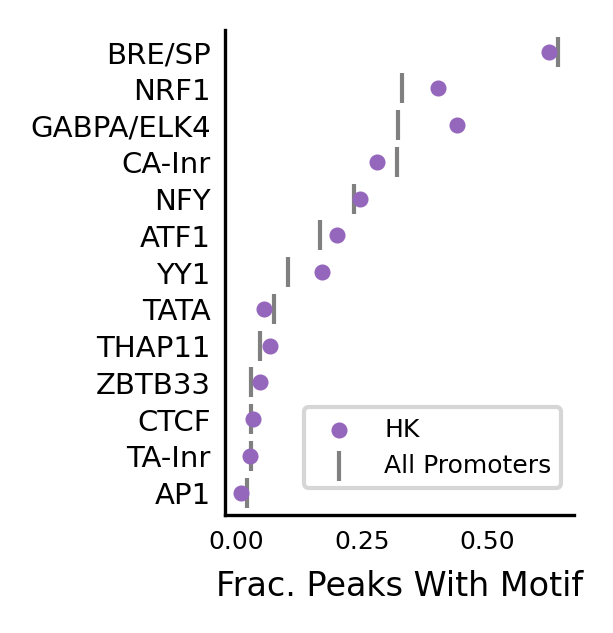

In [141]:
from collections import defaultdict

def plot_motif_enrichment_in_cCREs_condensed_hk(peak_hit_counts, ccre_annots, hk_annots):
    
    annots_to_sizes = {"All Promoters" : 50, "HK" : 45, "NotHK" : 45}
    
    annot_vals = defaultdict(lambda : [])
    
    num_peaks_in_promoters = np.sum(ccre_annots["PLS"])
    
    motif_names_to_plot = []
    motif_keys = range(peak_hit_counts.shape[1])
    for motif_index in motif_keys:
        motif_names_to_plot.append(motif_keys_to_labels[motif_index])
            
        total_peaks_with_motif = np.sum(peak_hit_counts[ccre_annots["PLS"], motif_index] > 0)

        overlap_peaks = np.sum(ccre_annots["PLS"] * hk_annots)
        overlap_peaks_with_motif = np.sum(peak_hit_counts[ccre_annots["PLS"] * hk_annots, motif_index] > 0)
        annot_vals["HK"].append(overlap_peaks_with_motif / overlap_peaks)
            
        annot_vals["All Promoters"].append(total_peaks_with_motif / num_peaks_in_promoters)

    motif_keys = range(len(motif_names_to_plot))
        
    plot_order = np.argsort(annot_vals["All Promoters"])[::-1]
        
    plt.figure(figsize=(1.5,2.1), dpi=300)
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Promoters":
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=key if add_to_legend else "",
                            color="gray",
                            linewidth=1,
                            s=50,
                            zorder=10 - i, marker="|")
            else:
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=key if add_to_legend else "",
                            color=class_to_colors[key],
                            edgecolor=class_to_colors[key],
                            linewidth=0.5,
                            s=45,
                            zorder=10 - i, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="lower right", bbox_to_anchor=(1., 0.03))
    plt.yticks(motif_keys[::-1], np.array(motif_names_to_plot)[plot_order], fontsize=7)
    plt.tick_params(left=False, length=0)
    plt.xticks([0.0, 0.25, 0.5], fontsize=6)
    plt.xlabel("Frac. Peaks With Motif", fontsize=8)
    #plt.ylabel("Motif", fontsize=8)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
    
plot_motif_enrichment_in_cCREs_condensed_hk(motif_hit_counts, ccre_annots, hk_annots)

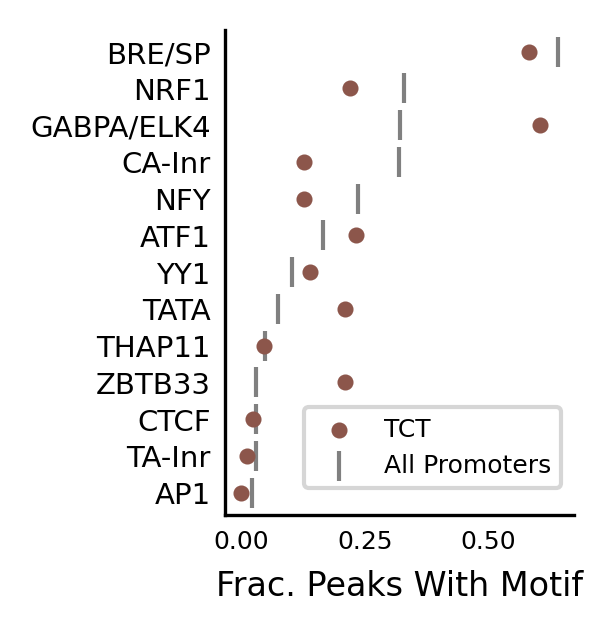

In [51]:
from collections import defaultdict

def plot_motif_enrichment_in_cCREs_condensed_tct(peak_hit_counts, ccre_annots, tct_annots):
    
    annots_to_sizes = {"All Promoters" : 50, "TCT" : 45, "NotTCT" : 45}
    
    annot_vals = defaultdict(lambda : [])
    
    num_peaks_in_promoters = np.sum(ccre_annots["PLS"])
    
    motif_names_to_plot = []
    motif_keys = range(peak_hit_counts.shape[1])
    for motif_index in motif_keys:
        motif_names_to_plot.append(motif_keys_to_labels[motif_index])
            
        total_peaks_with_motif = np.sum(peak_hit_counts[ccre_annots["PLS"], motif_index] > 0)

        overlap_peaks = np.sum(ccre_annots["PLS"] * tct_annots)
        overlap_peaks_with_motif = np.sum(peak_hit_counts[ccre_annots["PLS"] * tct_annots, motif_index] > 0)
        annot_vals["TCT"].append(overlap_peaks_with_motif / overlap_peaks)
            
        annot_vals["All Promoters"].append(total_peaks_with_motif / num_peaks_in_promoters)

    motif_keys = range(len(motif_names_to_plot))
        
    plot_order = np.argsort(annot_vals["All Promoters"])[::-1]
        
    plt.figure(figsize=(1.5,2.1), dpi=300)
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Promoters":
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=key if add_to_legend else "",
                            color="gray",
                            linewidth=1,
                            s=50,
                            zorder=10 - i, marker="|")
            else:
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=key if add_to_legend else "",
                            color=class_to_colors[key],
                            edgecolor=class_to_colors[key],
                            linewidth=0.5,
                            s=45,
                            zorder=10 - i, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="lower right", bbox_to_anchor=(1., 0.03))
    plt.yticks(motif_keys[::-1], np.array(motif_names_to_plot)[plot_order], fontsize=7)
    plt.tick_params(left=False, length=0)
    plt.xticks([0.0, 0.25, 0.5], fontsize=6)
    plt.xlabel("Frac. Peaks With Motif", fontsize=8)
    #plt.ylabel("Motif", fontsize=8)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
    
plot_motif_enrichment_in_cCREs_condensed_tct(motif_hit_counts, ccre_annots, tct_annots)

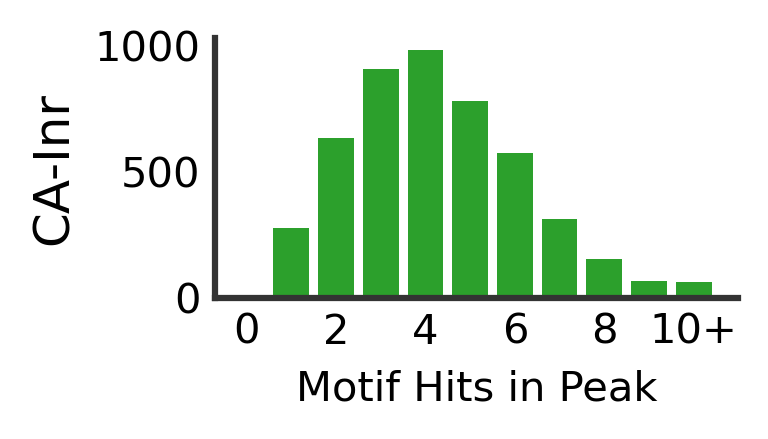

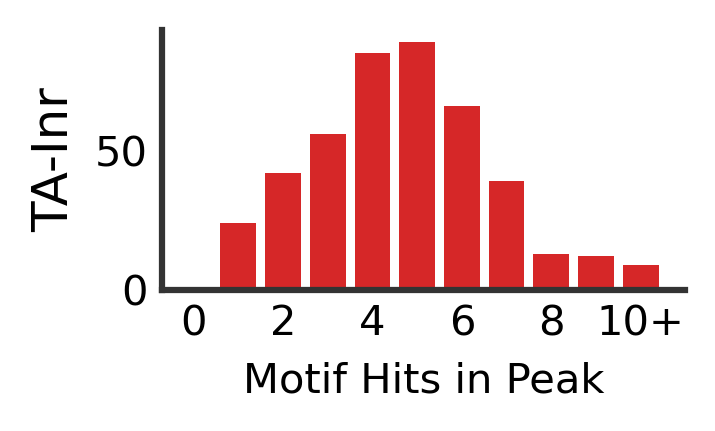

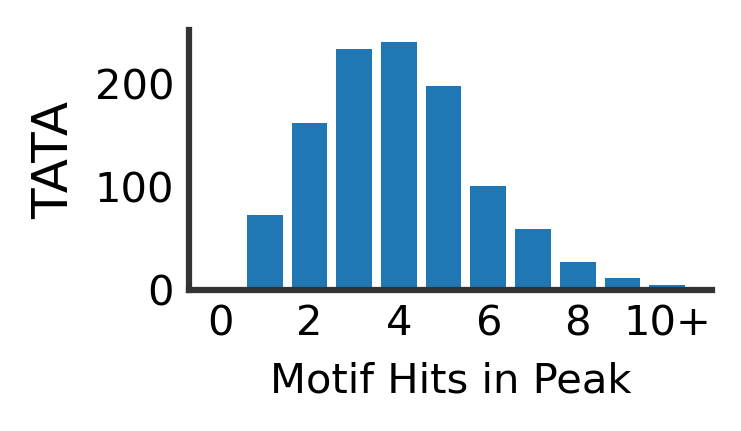

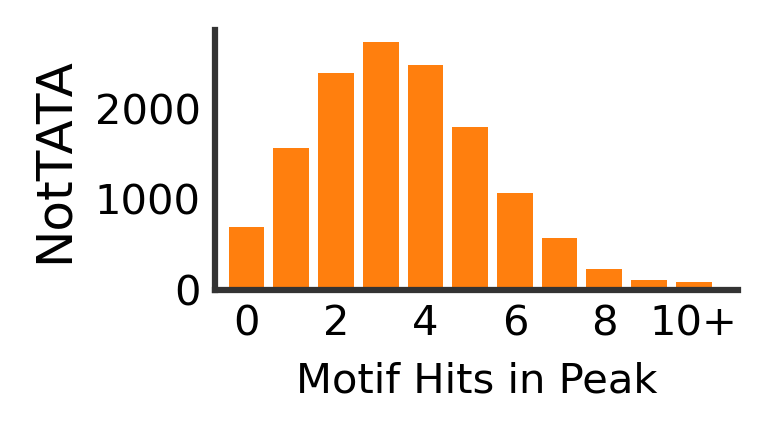

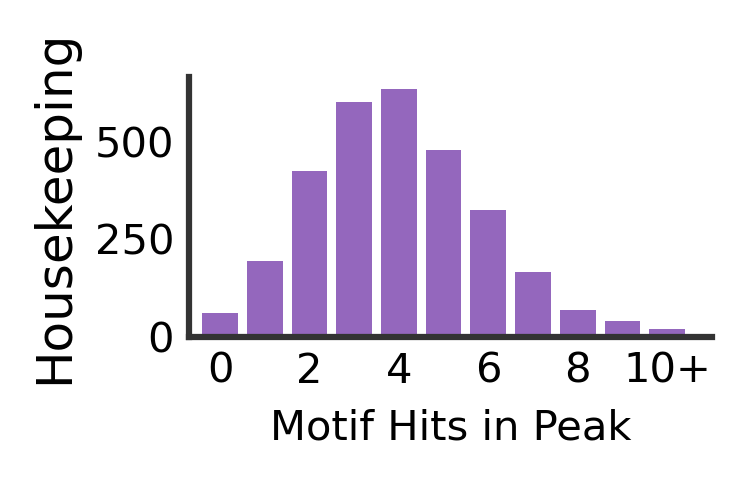

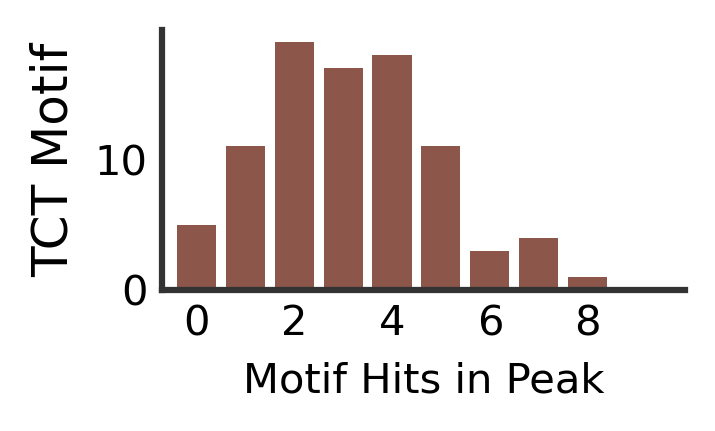

In [52]:
def plot_motif_complexity_across_ccres(motif_hit_counts, motif_and_promoter_bools, hk_annots, tct_annots):
    
    for key in motif_and_promoter_bools.keys():
        motif_hit_counts_annot = motif_hit_counts[motif_and_promoter_bools[key]]
        motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

        stop_point = 10
        hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
        hist_x = list(hist_x[:stop_point]) + [stop_point]

        plt.figure(figsize=(2.25,1.125), dpi=300)
        plt.bar(hist_x, hist_y, color=motifs_to_colors[key])

        plt.xlabel("Motif Hits in Peak", fontsize=10)
        plt.ylabel(key, fontsize=12)

        xticklabels = []
        for i in hist_x:
            if i < stop_point:
                xticklabels.append(str(i))
            else:
                xticklabels.append(str(stop_point) + "+")

        plt.xticks(hist_x[::2], xticklabels[::2])
        plt.xlim(-0.7, len(hist_x))
        plt.tick_params("both", length=0)

        ax = plt.gca()
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.show()
        
        
    motif_hit_counts_annot = motif_hit_counts[hk_annots]
    motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

    hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

    stop_point = 10
    hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
    hist_x = list(hist_x[:stop_point]) + [stop_point]

    plt.figure(figsize=(2.25,1.125), dpi=300)
    plt.bar(hist_x, hist_y, color=class_to_colors["HK"])

    plt.xlabel("Motif Hits in Peak", fontsize=10)
    plt.ylabel("Housekeeping", fontsize=12)

    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")

    plt.xticks(hist_x[::2], xticklabels[::2])
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()
    
    
    
    motif_hit_counts_annot = motif_hit_counts[tct_annots]
    motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

    hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

    stop_point = 9
    hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
    hist_x = list(hist_x[:stop_point]) + [stop_point]

    plt.figure(figsize=(2.25,1.125), dpi=300)
    plt.bar(hist_x, hist_y, color=class_to_colors["TCT"])

    plt.xlabel("Motif Hits in Peak", fontsize=10)
    plt.ylabel("TCT Motif", fontsize=12)

    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")

    plt.xticks(hist_x[::2], xticklabels[::2])
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0)

    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()



plot_motif_complexity_across_ccres(motif_hit_counts, motif_and_promoter_bools, hk_annots, tct_annots)

In [36]:
def get_motif_jaccard_matrix(peak_hit_counts):
    peak_hit_counts = (peak_hit_counts > 0) * 1
    num_motifs = peak_hit_counts.shape[1]
    
    jaccards = np.zeros((num_motifs, num_motifs))
    for i in range(num_motifs):
        motif_i_peak_hits = peak_hit_counts[:, i]
        for j in range(i + 1, num_motifs):
            motif_j_peak_hits = peak_hit_counts[:, j]
            
            intersection = np.dot(motif_i_peak_hits, motif_j_peak_hits)
            union = np.sum((motif_i_peak_hits + motif_j_peak_hits) > 0)
            jaccards[i, j] = intersection / union
            jaccards[j, i] = jaccards[i, j]
            
    return jaccards

def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix

In [37]:
from plot_utils import get_continuous_cmap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def get_upper_right_highlight_coords(n_rows):
    # assuming n_rows = n_cols
    # want (5.5, 0.5), (4.5, 0.5), (4.5, 1.5), ..., (0.5, 5.5)
    
    curr_x = 0.5
    curr_y = -0.5
    
    coords_list = [(curr_x, curr_y)]
    while curr_x < n_rows - 0.5:
        curr_y += 1
        coords_list.append((curr_x, curr_y))
        curr_x += 1
        coords_list.append((curr_x, curr_y))
        
    coords_list.append((n_rows - 0.5, -0.5))
    coords_list.append(coords_list[0])  # back to start
    
    return np.array(coords_list)


def plot_jaccard_matrix(jaccard_matrix, inds=None):
    num_motifs = jaccard_matrix.shape[0]
    
    if inds is not None:
        assert len(inds) == num_motifs, inds
        jaccard_matrix = jaccard_matrix[inds][:, inds]
        ticklabels = [k + 1 for k in inds]
    else:
        ticklabels = range(num_motifs)
    
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    #cmap = get_continuous_cmap(["#63001C", "#F94144", "#FF927C"])
    #cmap.set_bad('white',1.)
    plt.imshow(jaccard_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    # Loop over data dimensions and create text annotations.
    #for i in range(num_motifs):
    #    for j in range(num_motifs):
    #        if i != j:
    #            text = "%.2f" % np.abs(jaccard_matrix[i, j])
    #            text = ax.text(j, i, text,
    #                           ha="center", va="center", color="w", fontsize=5)
    
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)
    
    # add squiggles around parts of plot to highlight
    
    # sorry I changed my mind about which corner of the plot I wanted highlighted after I wrote the function
    #bottom_left_highlight_coords = get_upper_right_highlight_coords(num_motifs)[:, ::-1]
    #bottom_left_highlight = Polygon(bottom_left_highlight_coords)
    #ax.add_collection(PatchCollection([bottom_left_highlight],
    #                                  color="w", facecolor="none",
    #                                  linewidth=3, clip_on=False))
    #ax.add_collection(PatchCollection([bottom_left_highlight],
    #                                  color="k", facecolor="none",
    #                                  linewidth=1.5, clip_on=False))


    cbar = plt.colorbar(label=r'$\frac{|Intersection|}{|Union|}$ of Motif Hits',
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()

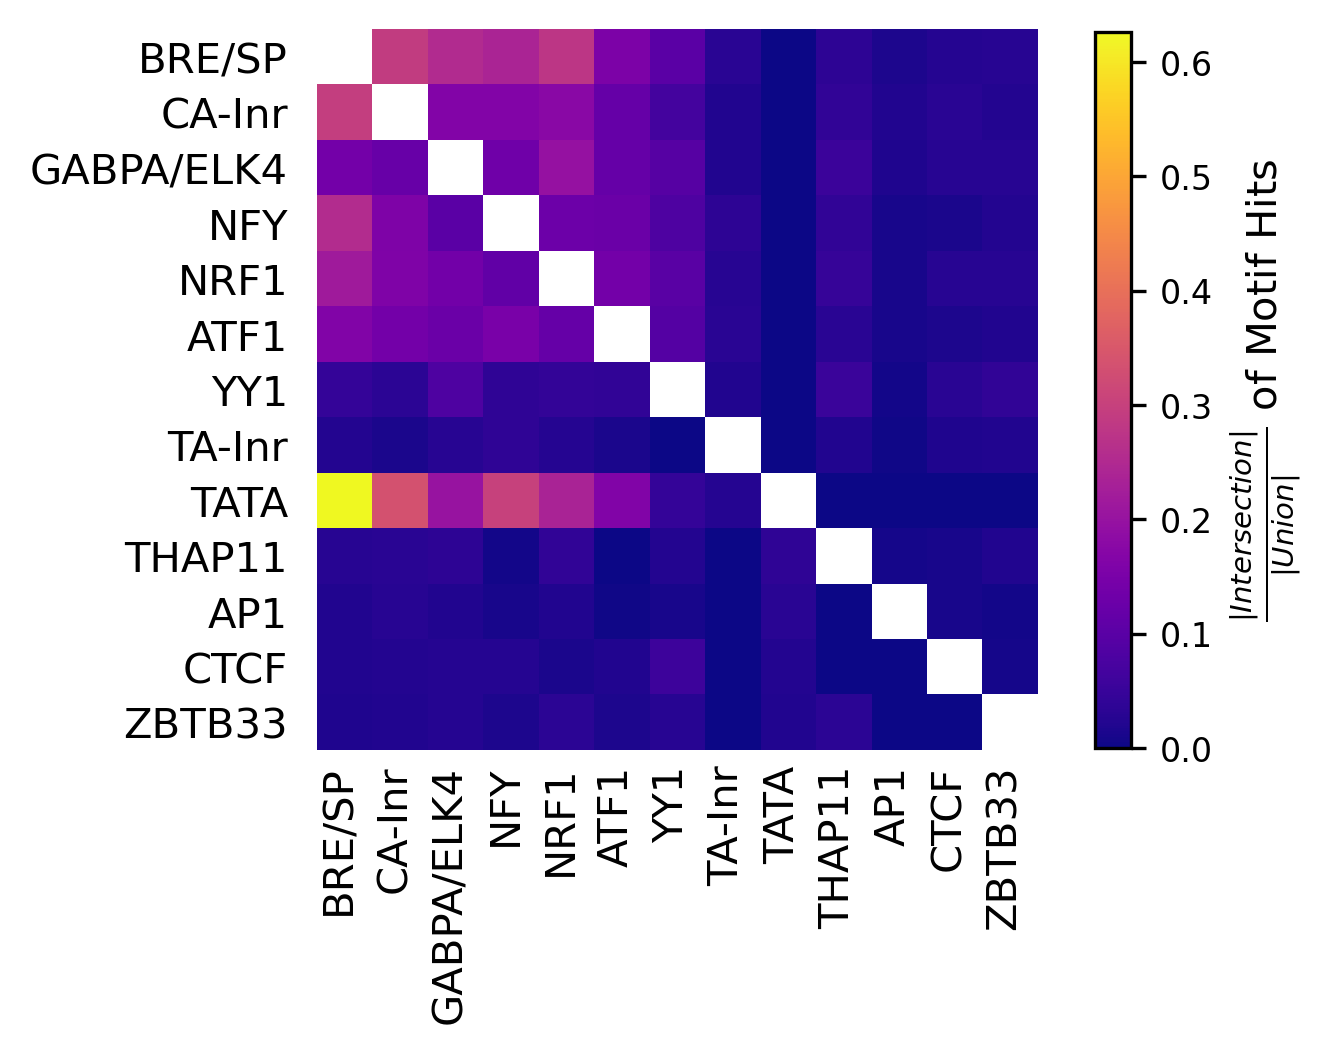

In [38]:
tata_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[motif_and_promoter_bools["TATA"]])
nottata_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[motif_and_promoter_bools["NotTATA"]])
combo_jaccard_matrix = combine_two_symmetric_matrices(tata_jaccard_matrix,
                                                      nottata_motif_jaccard_matrix)
plot_jaccard_matrix(combo_jaccard_matrix)

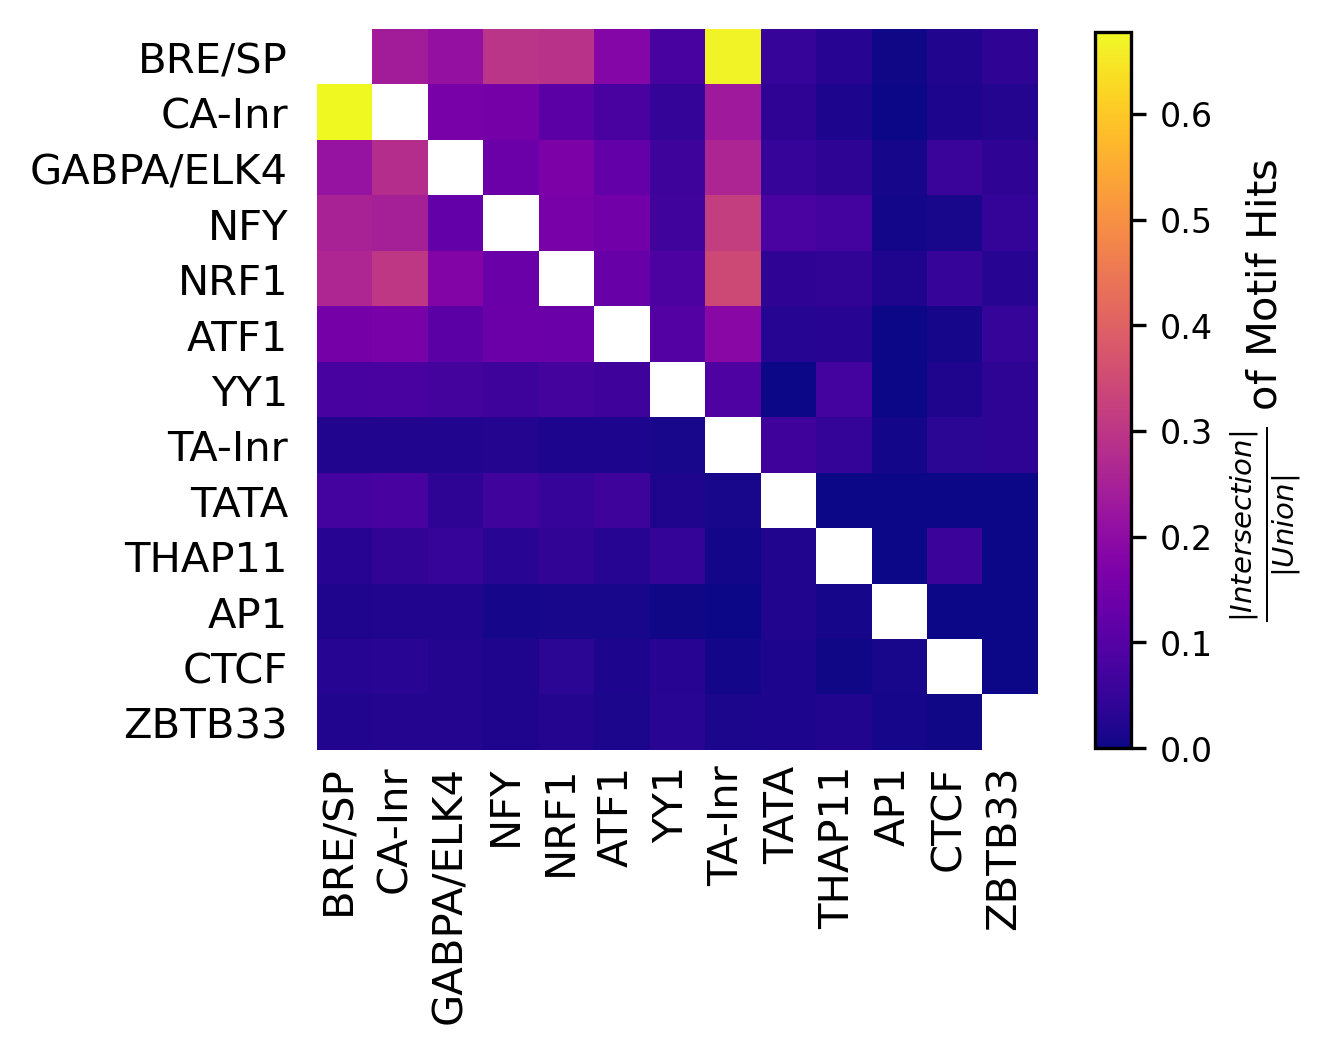

In [39]:
ca_inr_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[motif_and_promoter_bools["CA-Inr"]])
ta_inr_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[motif_and_promoter_bools["TA-Inr"]])
combo_jaccard_matrix = combine_two_symmetric_matrices(ca_inr_jaccard_matrix,
                                                      ta_inr_motif_jaccard_matrix)
plot_jaccard_matrix(combo_jaccard_matrix)

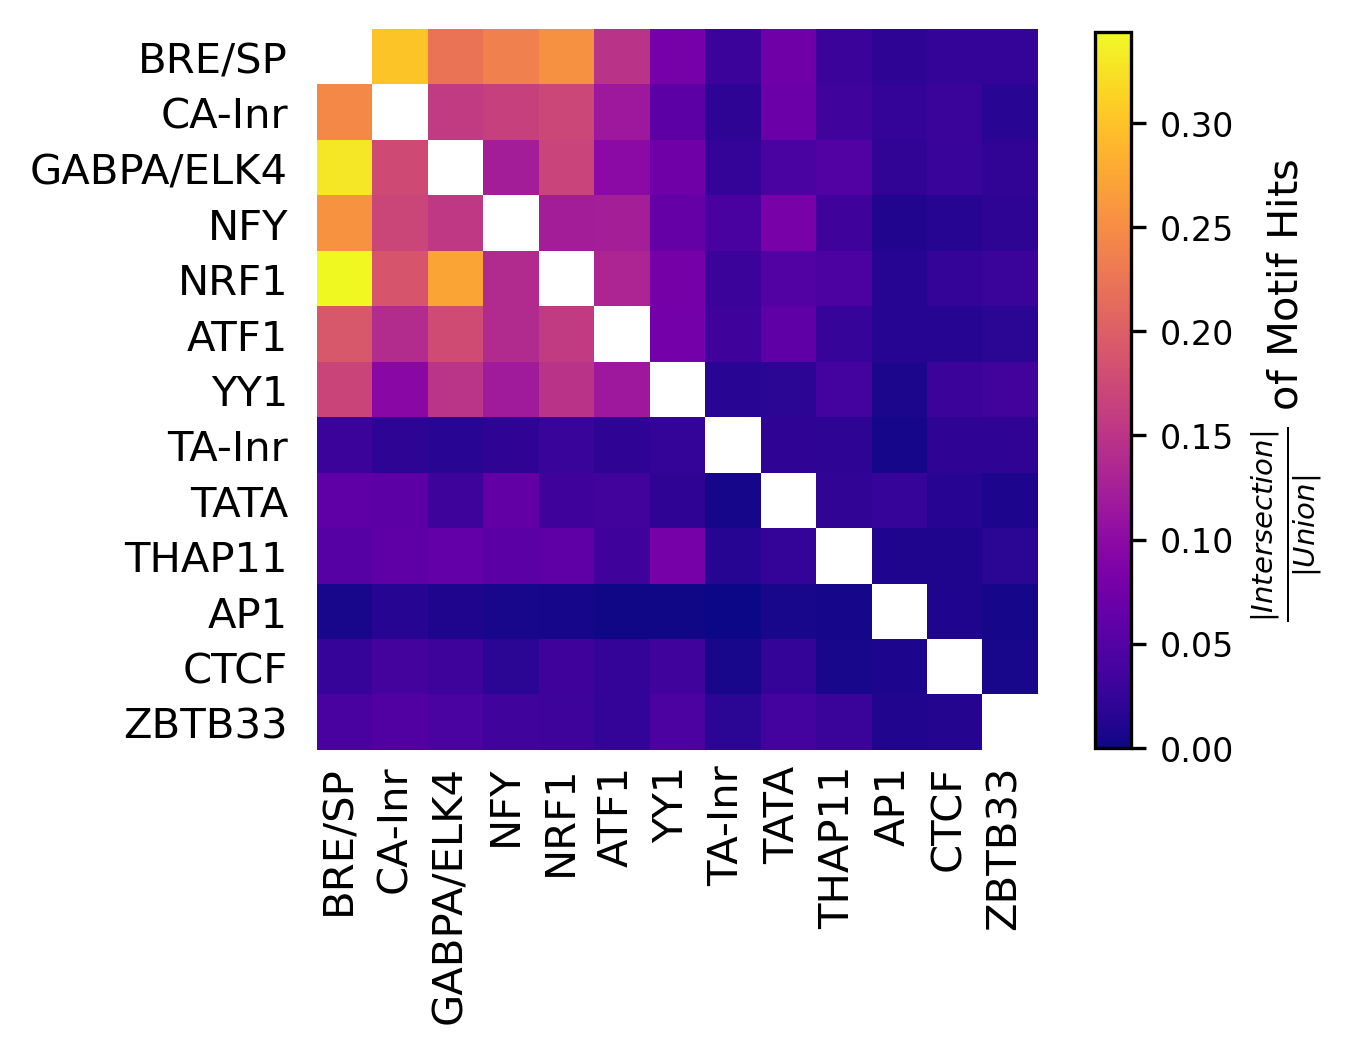

In [40]:
hk_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[ccre_annots["PLS"] * hk_annots])
nothk_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[ccre_annots["PLS"] * (~ hk_annots)])
combo_jaccard_matrix = combine_two_symmetric_matrices(hk_jaccard_matrix,
                                                      nothk_motif_jaccard_matrix)
plot_jaccard_matrix(combo_jaccard_matrix)

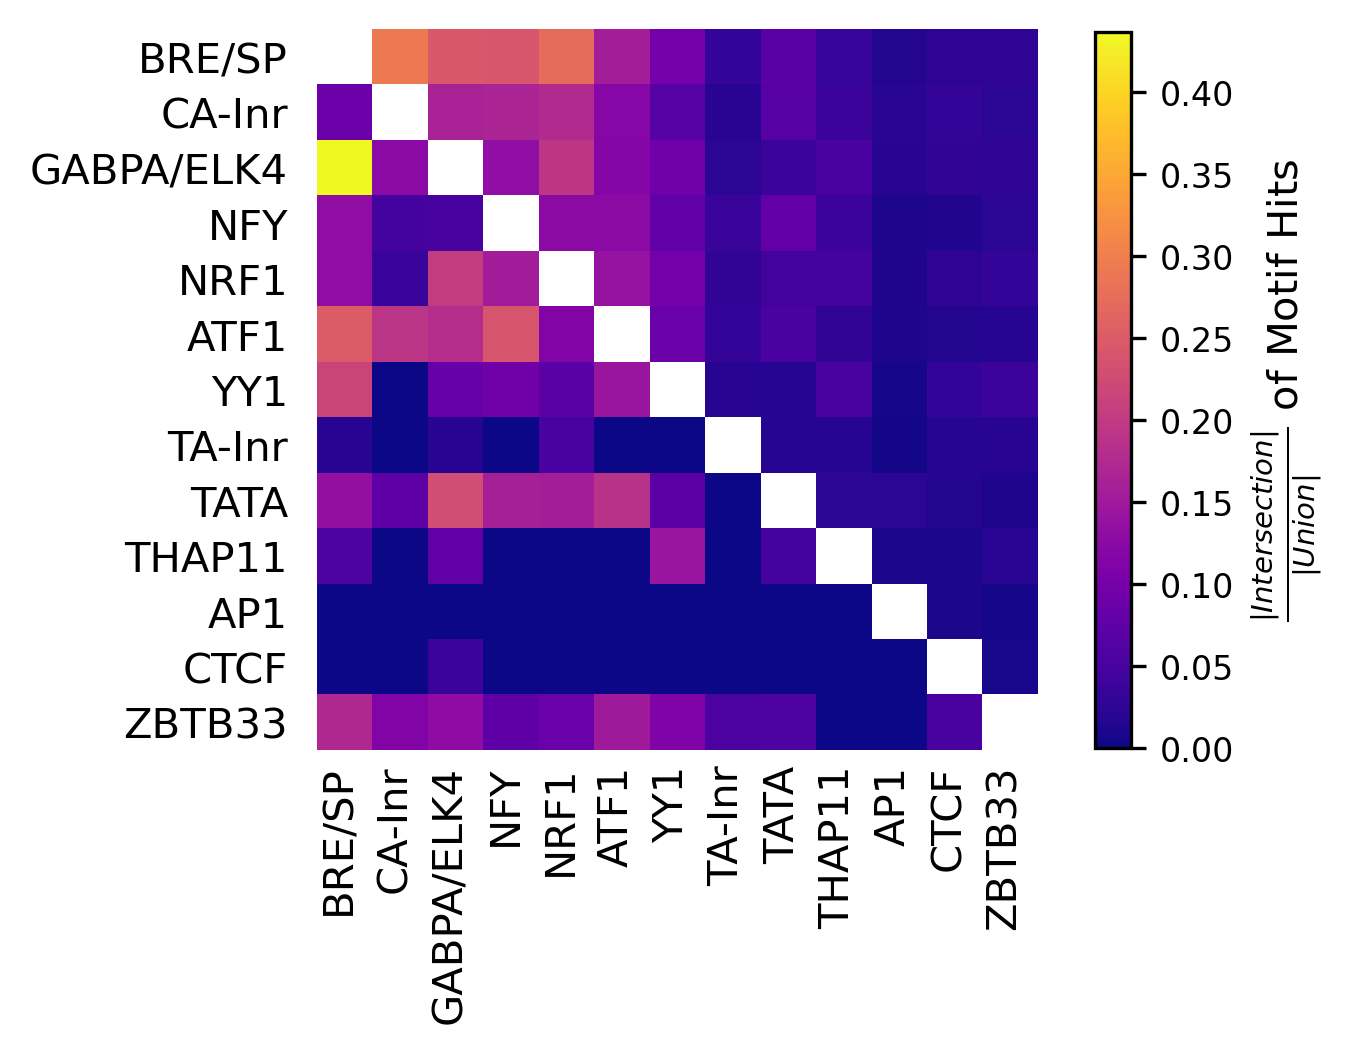

In [41]:
hk_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[ccre_annots["PLS"] * tct_annots])
nothk_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts[ccre_annots["PLS"] * (~ tct_annots)])
combo_jaccard_matrix = combine_two_symmetric_matrices(hk_jaccard_matrix,
                                                      nothk_motif_jaccard_matrix)
plot_jaccard_matrix(combo_jaccard_matrix)